In [123]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pytorch_msssim import SSIM, MS_SSIM
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [167]:
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = "cpu"
# TODO: make sure to .to(device) the class later, and also set up gpu

# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0
# number of epochs
num_epochs = 100
# batch size for training
batch_size = 32
# height and width of input image
img_size = 64
# number of channels
nc0 = 1
nc1 = 4
nc2 = 8
nc3 = 16
# threshold
thresh = 0
# learning rate
lr = 0.002
# beta1 for Adam
beta1 = 0.5
# real label
real_label = 1.0
# fake label
fake_label = 0.0
# number of extra times to run the discriminator than the encdec per epoch
num_dis = 1
# coefficient of the discriminator loss in training
cof_dis = 9e-3

In [168]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [169]:
class FontDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.fontlist = pd.read_csv(csv_file, sep=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fontlist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #c = chr(ord('A') + np.random.randint(0, 26))
        img_path1 = os.path.join(self.root_dir, "R/", f"{idx}.npy")
        img_path2 = os.path.join(self.root_dir, "B/", f"{idx}.npy")

        img1 = np.load(img_path1)
        img2 = np.load(img_path2)

        img1 = img1[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]
        img2 = img2[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        sample = {'c1': img1, 'c2': img2}

        return sample

In [170]:
# From https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/3
def get_gaussian_kernel(kernel_size=3, sigma=2, channels=3):
    # Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
    x_coord = torch.arange(kernel_size)
    x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
    y_grid = x_grid.t()
    xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()

    mean = (kernel_size - 1)/2.
    variance = sigma**2.

    # Calculate the 2-dimensional gaussian kernel which is
    # the product of two gaussian distributions for two different
    # variables (in this case called x and y)
    gaussian_kernel = (1./(2.*math.pi*variance)) *\
                      torch.exp(
                          -torch.sum((xy_grid - mean)**2., dim=-1) /\
                          (2*variance)
                      )

    # Make sure sum of values in gaussian kernel equals 1.
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

    # Reshape to 2d depthwise convolutional weight
    gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
    gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

    gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                                kernel_size=kernel_size, groups=channels, bias=False, padding=1)

    gaussian_filter.weight.data = gaussian_kernel
    gaussian_filter.weight.requires_grad = False
    
    return gaussian_filter

In [171]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.conv1 = nn.Conv2d(nc0, nc1, 3, padding=1)
        self.conv1same = nn.Conv2d(nc1, nc1, 3, padding=1)
        self.conv2 = nn.Conv2d(nc1, nc2, 3, padding=1)
        self.conv3 = nn.Conv2d(nc2, nc2, 3, padding=1)
        self.conv2back = nn.Conv2d(nc2, nc1, 3, padding=1)
        self.conv1back = nn.Conv2d(nc1, nc0, 3, padding=1)
        
        self.conv1strided = nn.Conv2d(nc1, nc1, 3, stride=2, padding=1)
        self.conv2strided = nn.Conv2d(nc2, nc2, 3, stride=2, padding=1)

        self.deconv1 = nn.ConvTranspose2d(nc1, nc0, 3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(nc2, nc1, 3, padding=1)
        self.deconv1strided = nn.ConvTranspose2d(nc1, nc1, 3, stride=2, padding=1, output_padding=1)
        self.deconv2strided = nn.ConvTranspose2d(nc2, nc2, 3, stride=2, padding=1, output_padding=1)

        self.batchnorm0 = nn.BatchNorm2d(nc0)
        self.batchnorm1 = nn.BatchNorm2d(nc1)
        self.batchnorm2 = nn.BatchNorm2d(nc2)
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.threshold = nn.Threshold(thresh, 0)
        
        self.gaussian_filter = get_gaussian_kernel(kernel_size = 3, sigma=2, channels=nc1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyrelu(x)
        x = self.conv2(x)
        x = self.leakyrelu(x)
        x, idx1 = self.pool(x)
        
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x, idx2 = self.pool(x)
        
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x, idx3 = self.pool(x)
        
        x = self.unpool(x, idx3)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx2)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx1)
        x = self.conv2back(x)
        x = self.leakyrelu(x)
        
        x = self.gaussian_filter(x)
        x = self.conv1same(x)
        x = self.leakyrelu(x)
        x = self.conv1same(x)
        x = self.leakyrelu(x)
        
        x = self.conv1back(x)
        x = self.leakyrelu(x)
        
        x = self.tanh(x)
        
        return x

In [172]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1 x img_size x img_size
            nn.Conv2d(nc0, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc1),
            nn.ReLU(inplace=True),
            # 4 x img_size/2 x img_size/2
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            
            # 8 x img_size/4 x img_size/4
            nn.Conv2d(nc2, nc3, 4, stride=2, padding=1),
            nn.BatchNorm2d(nc3),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc3, nc3, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc3, nc3, 3, padding=1),
            nn.ReLU(inplace=True),
            
            # 16 x img_size/8 x img_size/8
            nn.Flatten(),
            nn.Linear(nc3 * img_size // 8 * img_size // 8, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [173]:
class LocalDiscriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1 x img_size x img_size
            nn.Conv2d(nc0, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc1),
            nn.ReLU(inplace=True),
            # 4 x img_size/2 x img_size/2
            nn.Conv2d(nc2, nc2, 4, stride=2, padding=1),
#             nn.BatchNorm2d(nc2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(nc2, nc2, 3, padding=1),
            nn.ReLU(inplace=True),
            
            # 8 x img_size/4 x img_size/4
            nn.Flatten(),
            nn.Linear(nc2 * img_size // 4 * img_size // 4, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [174]:
def main():
    dataset = FontDataset(csv_file=fonts_csv, 
                        root_dir=dataroot, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(0.5, 0.5),
#                             AddGaussianNoise(0., 0.05),
                        ]))
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    
    encdec = EncoderDecoder()
    # use this line to continue training instead of starting a new one
    # encdec.load_state_dict(torch.load('encdec.pt'))
    
    criterionED_l1 = nn.L1Loss()
    criterionED_ssim = MS_SSIM(win_size=3, data_range=1, size_average=True, channel=1)
    criterionED_ssim_local = SSIM(win_size=5, data_range=1, size_average=True, channel=1)
    optimizerED = optim.Adam(encdec.parameters(), lr=lr)

    disc = Discriminator()
    criterionD = nn.BCELoss()
    optimizerD = optim.Adam(disc.parameters(), lr=lr)
    
    # training loop
    for epoch in range(num_epochs):
        running_lossD = 0.0
        running_loss_disc = 0.0
        running_loss_l1 = 0.0
        running_loss_ssim = 0.0
        
        for it in range(num_dis):
            for i, data in enumerate(dataloader):
                disc.zero_grad()
                
                b_size = data['c2'].size(0)
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                
                outputD = disc(data['c2']).view(-1)
                lossD_real = criterionD(outputD, label)
                lossD_real.backward()

                # all fake batch
                outputED = encdec(data['c1'])
                label.fill_(fake_label)
                outputD = disc(outputED.detach()).view(-1)
                lossD_fake = criterionD(outputD, label)
                lossD_fake.backward()

                lossD = lossD_real + lossD_fake
                optimizerD.step()

        for i, data in enumerate(dataloader):
            ###########################
            # update disc
            ###########################
            disc.zero_grad()
            # all real batch
            b_size = data['c2'].size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            outputD = disc(data['c2']).view(-1)
            lossD_real = criterionD(outputD, label)
            lossD_real.backward()
            
            # all fake batch
            outputED = encdec(data['c1'])
            
            
            label.fill_(fake_label)
            outputD = disc(outputED.detach()).view(-1)
            lossD_fake = criterionD(outputD, label)
            lossD_fake.backward()

            lossD = lossD_real + lossD_fake
            optimizerD.step()

            ###########################
            # update encdec
            ###########################
            encdec.zero_grad()
            # rerun disc
            label.fill_(real_label)
            outputD = disc(outputED).view(-1)
            lossED_disc = criterionD(outputD, label)
            # run encdec
            lossED_l1 = criterionED_l1(outputED, data['c2'])
            lossED_local = 0.0
            for _ in range(3):
                x = np.random.randint(16, 48)
                y = np.random.randint(16, 48)
                outputED_patch = outputED[:, :, x-8:x+8, y-8:y+8]
                datac2_patch = data['c2'][:, :, x-8:x+8, y-8:y+8]
                lossED_local += criterionED_l1(outputED_patch, datac2_patch)
            outputED_norm = (outputED + 1) / 2
            datac2_norm = (data['c2'] + 1) / 2
            lossED_ssim = 1 - criterionED_ssim(outputED_norm, datac2_norm)

            lossED = cof_dis * lossED_disc + 0.16 * lossED_l1 + 0.84 * lossED_ssim + lossED_local / 3
            lossED.backward()
            optimizerED.step()
    
            running_lossD += lossD.item()
            running_loss_disc += lossED_disc.item()
            running_loss_l1 += lossED_l1.item()
            running_loss_ssim += lossED_ssim.item()
            if i % 50 == 49:
                print(f"Epoch {epoch+1}, Iteration {i+1}, Loss D {running_lossD}, Loss Disc {running_loss_disc}, Loss L1 {running_loss_l1}, Loss SSIM {running_loss_ssim}")
                running_lossD = 0.0
                running_loss_disc = 0.0
                running_loss_l1 = 0.0
                running_loss_ssim = 0.0
                
                fig = plt.figure(figsize=(8, 8))
                fig.add_subplot(1, 2, 1)
                plt.imshow(data['c1'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                fig.add_subplot(1, 2, 2)
                plt.imshow(outputED[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                plt.show()
    
    torch.save(encdec.state_dict(), 'encdecxd.pt')
    print("Done")

Epoch 1, Iteration 50, Loss D 1600.0599886290756, Loss Disc 514.310154914856, Loss L1 33.177141427993774, Loss SSIM 37.489868342876434


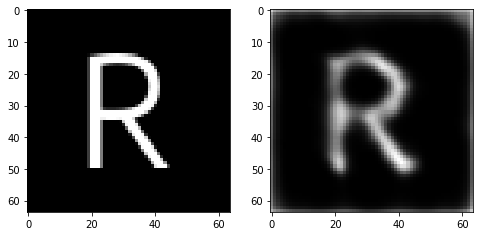

Epoch 1, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 8.01040780544281, Loss SSIM 12.711791515350342


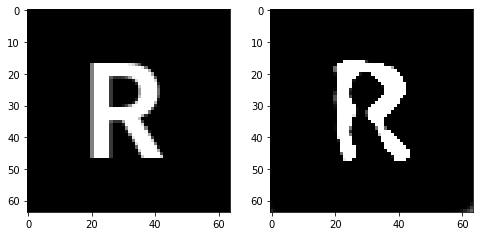

Epoch 2, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 6.238593891263008, Loss SSIM 9.468886375427246


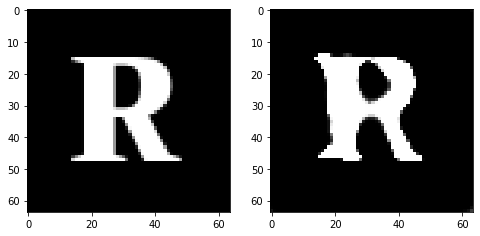

Epoch 2, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 5.990067683160305, Loss SSIM 9.220272719860077


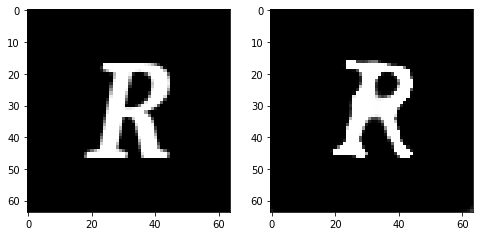

Epoch 3, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 5.838970392942429, Loss SSIM 8.873195171356201


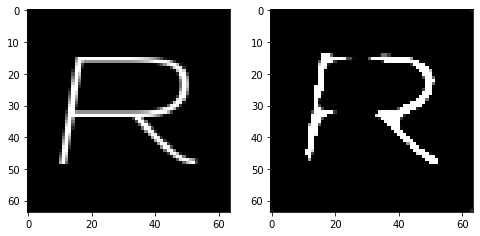

Epoch 3, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 5.570930317044258, Loss SSIM 8.449224531650543


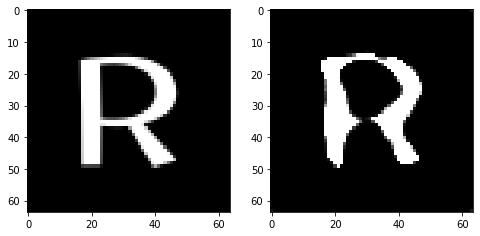

Epoch 4, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 5.4664420410990715, Loss SSIM 8.249361217021942


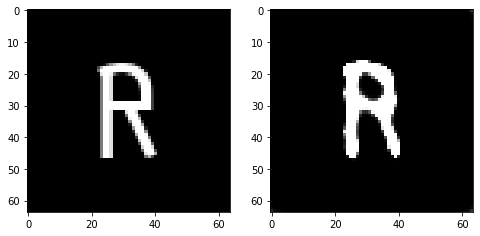

Epoch 4, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 5.401443250477314, Loss SSIM 8.157247543334961


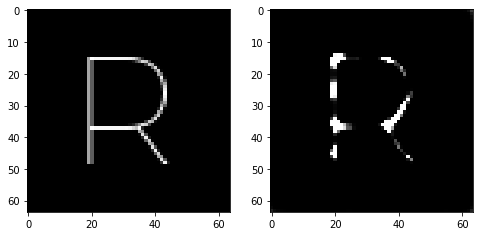

Epoch 5, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 5.226970665156841, Loss SSIM 7.843714654445648


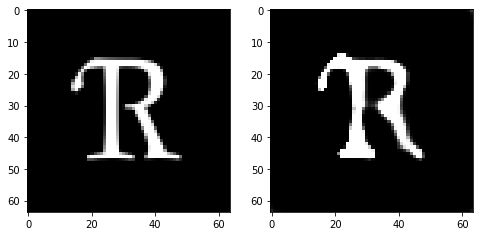

Epoch 5, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 5.047740057110786, Loss SSIM 7.54951137304306


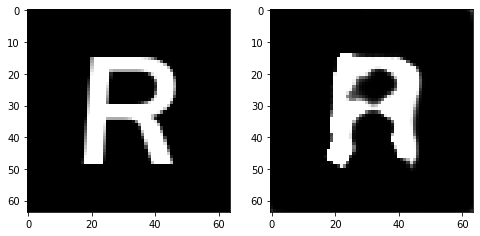

Epoch 6, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 5.005121827125549, Loss SSIM 7.4684337973594666


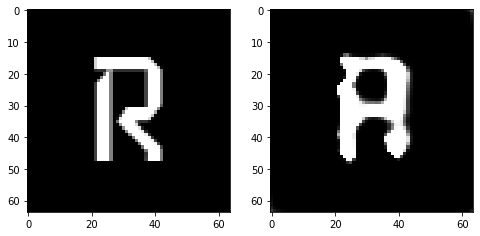

Epoch 6, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.774225831031799, Loss SSIM 6.89929324388504


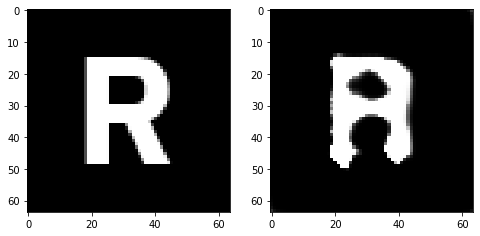

Epoch 7, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.8156730234622955, Loss SSIM 7.012117922306061


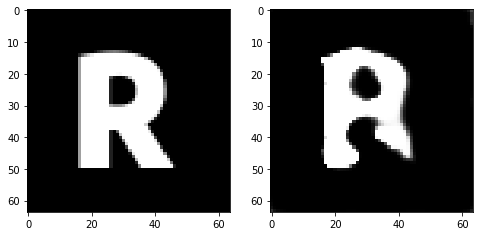

Epoch 7, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.6511287316679955, Loss SSIM 6.536478161811829


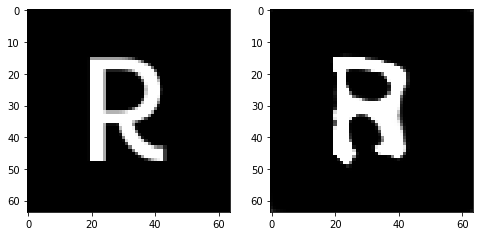

Epoch 8, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.5405483320355415, Loss SSIM 6.431593120098114


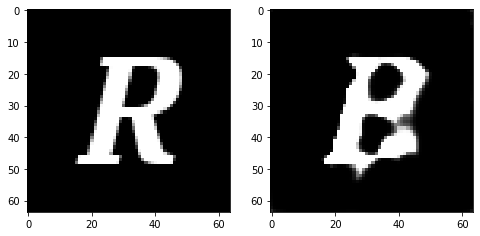

Epoch 8, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.455539368093014, Loss SSIM 6.056524038314819


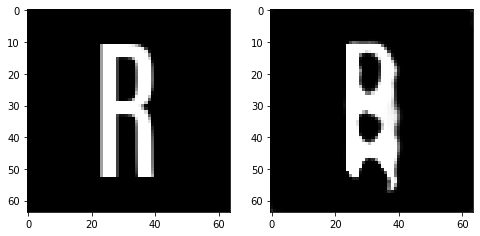

Epoch 9, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.317549079656601, Loss SSIM 5.860059857368469


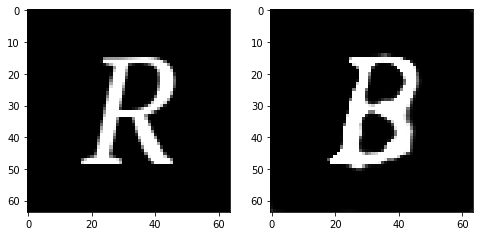

Epoch 9, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.223433576524258, Loss SSIM 5.612007975578308


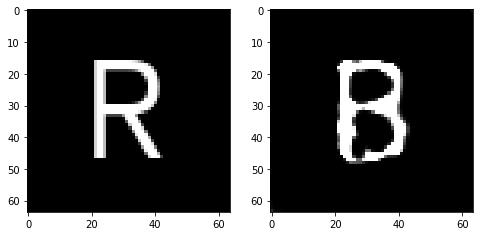

Epoch 10, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.185033142566681, Loss SSIM 5.588109850883484


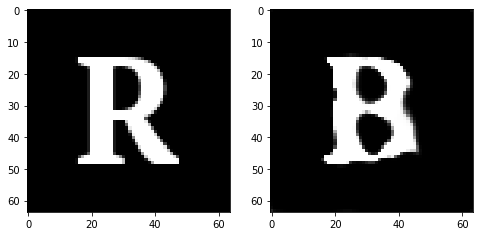

Epoch 10, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.118221789598465, Loss SSIM 5.454087138175964


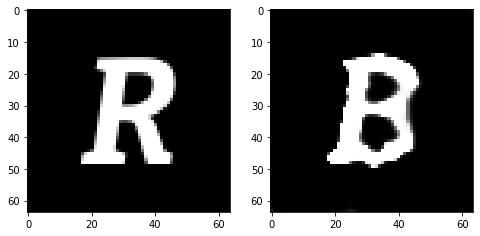

Epoch 11, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.032374672591686, Loss SSIM 5.329297780990601


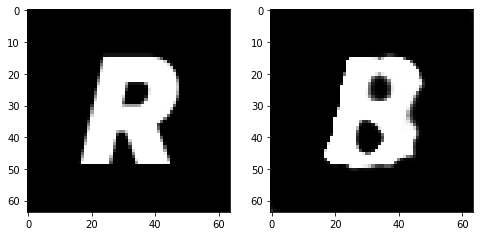

Epoch 11, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.053622230887413, Loss SSIM 5.359572410583496


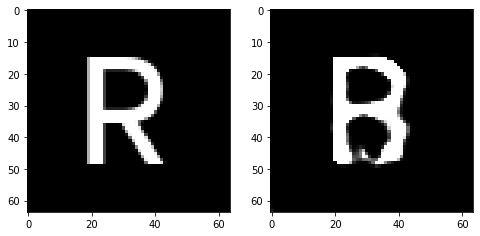

Epoch 12, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 4.000994227826595, Loss SSIM 5.2611448764801025


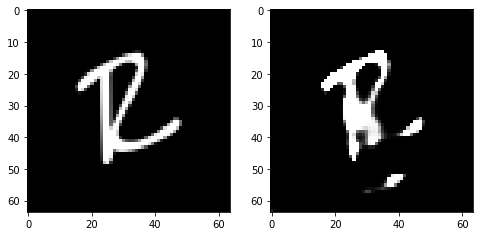

Epoch 12, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.942980781197548, Loss SSIM 5.2020891308784485


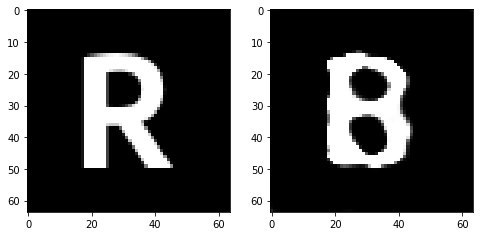

Epoch 13, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.9447884634137154, Loss SSIM 5.2005122900009155


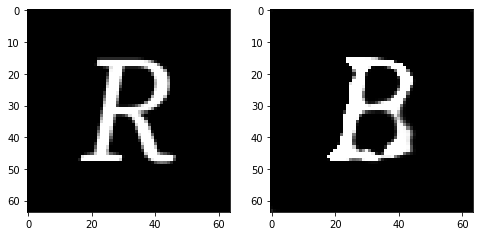

Epoch 13, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.9025191962718964, Loss SSIM 5.057019591331482


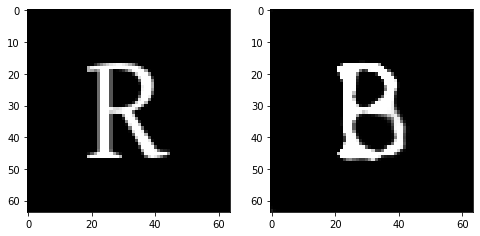

Epoch 14, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.89174272865057, Loss SSIM 5.067478597164154


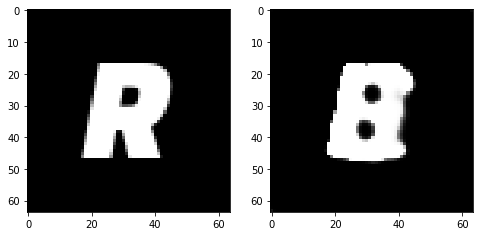

Epoch 14, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.872508205473423, Loss SSIM 5.064205050468445


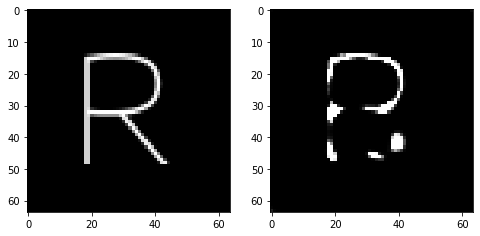

Epoch 15, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.8246952146291733, Loss SSIM 4.99346250295639


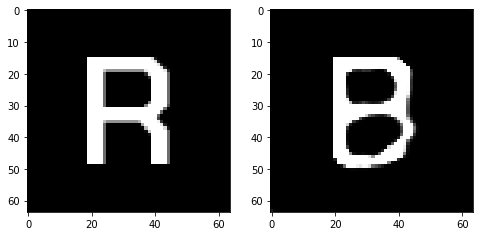

Epoch 15, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.8269733004271984, Loss SSIM 4.930667579174042


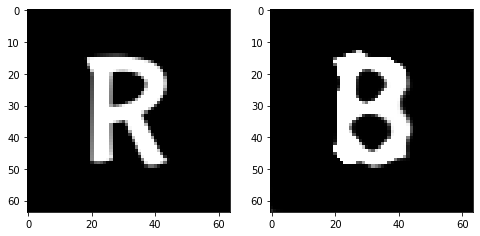

Epoch 16, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.840532384812832, Loss SSIM 4.961377918720245


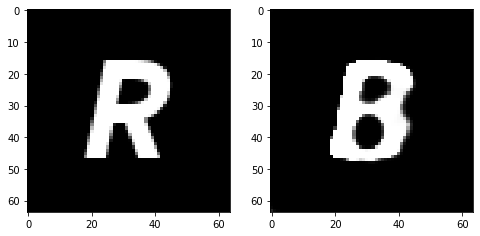

Epoch 16, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.7501903995871544, Loss SSIM 4.8026211857795715


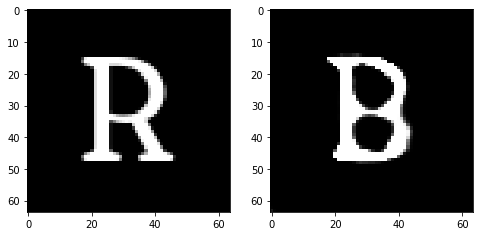

Epoch 17, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.7826523669064045, Loss SSIM 4.886889278888702


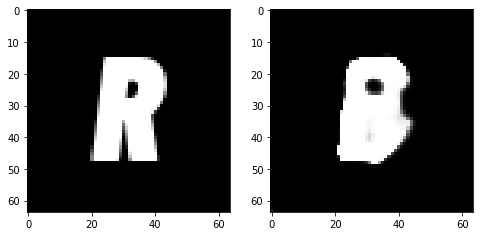

Epoch 17, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.731989435851574, Loss SSIM 4.789452910423279


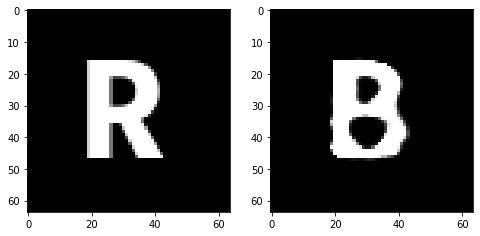

Epoch 18, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.69665964320302, Loss SSIM 4.778961777687073


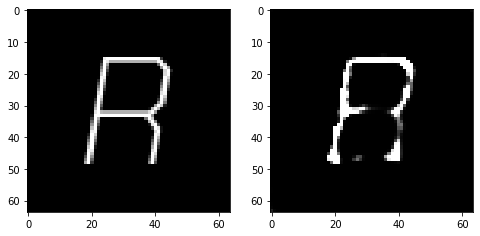

Epoch 18, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.7292171269655228, Loss SSIM 4.84522020816803


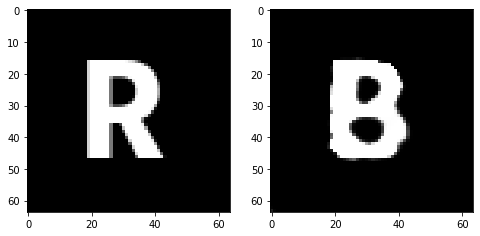

Epoch 19, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.7952617593109608, Loss SSIM 4.961423873901367


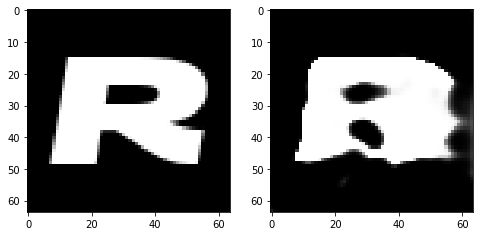

Epoch 19, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.6521848887205124, Loss SSIM 4.624121785163879


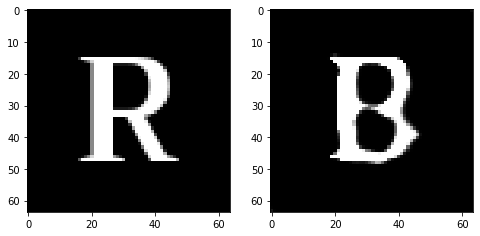

Epoch 20, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.64847531914711, Loss SSIM 4.659122705459595


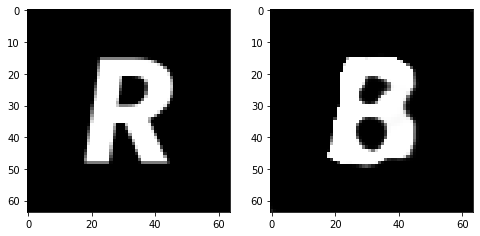

Epoch 20, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.6620768569409847, Loss SSIM 4.695853590965271


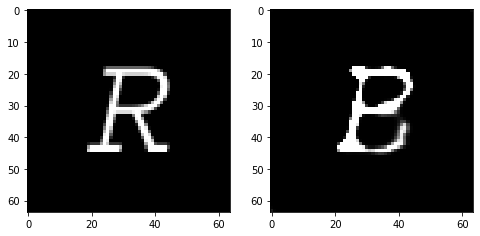

Epoch 21, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.6569289937615395, Loss SSIM 4.674942851066589


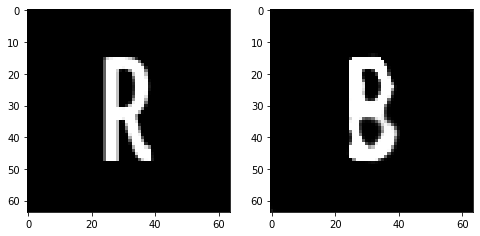

Epoch 21, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.594306219369173, Loss SSIM 4.56721818447113


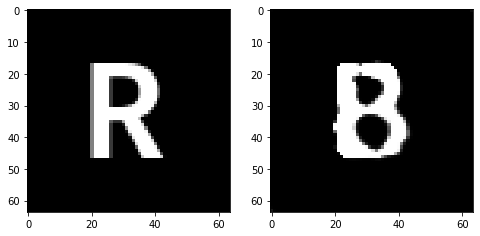

Epoch 22, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.5757133811712265, Loss SSIM 4.450190961360931


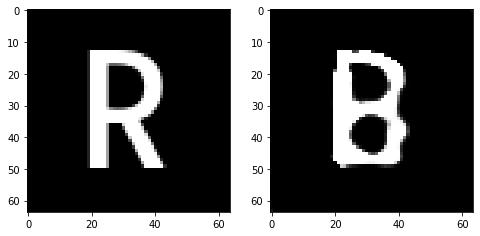

Epoch 22, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.549975845962763, Loss SSIM 4.5346949100494385


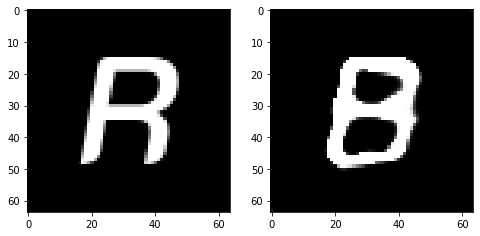

Epoch 23, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.6290240213274956, Loss SSIM 4.639705657958984


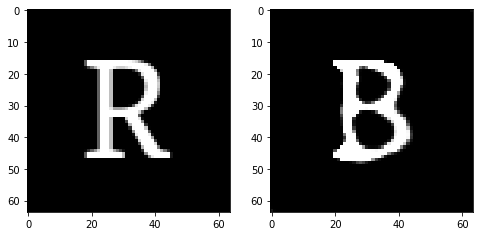

Epoch 23, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.5690489783883095, Loss SSIM 4.514085471630096


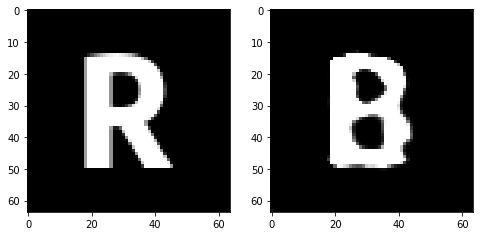

Epoch 24, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.5476445853710175, Loss SSIM 4.564951062202454


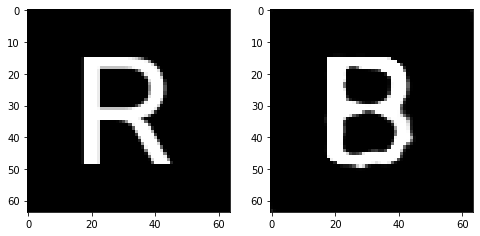

Epoch 24, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.517797078937292, Loss SSIM 4.371623873710632


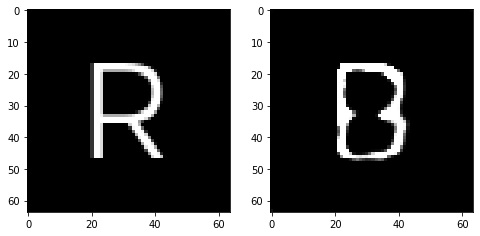

Epoch 25, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.6247862800955772, Loss SSIM 4.567636430263519


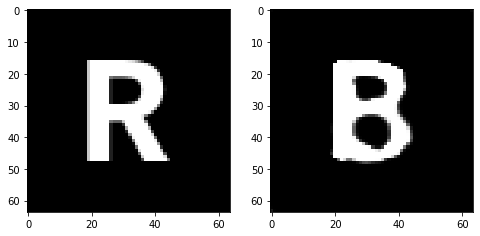

Epoch 25, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.464362058788538, Loss SSIM 4.4271204471588135


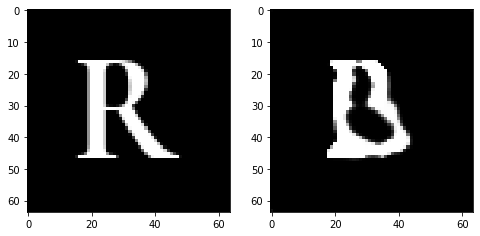

Epoch 26, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.4955792166292667, Loss SSIM 4.415434718132019


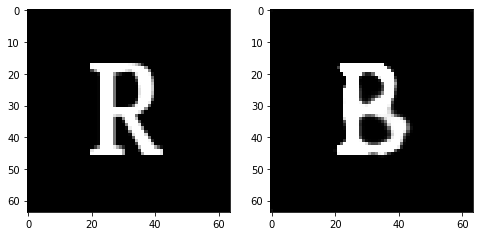

Epoch 26, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.493402447551489, Loss SSIM 4.411304771900177


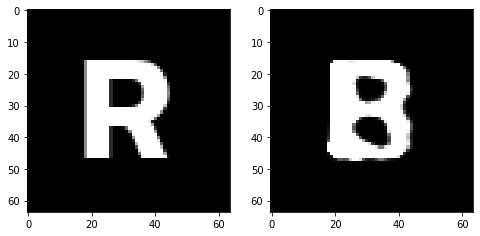

Epoch 27, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.452968053519726, Loss SSIM 4.346343636512756


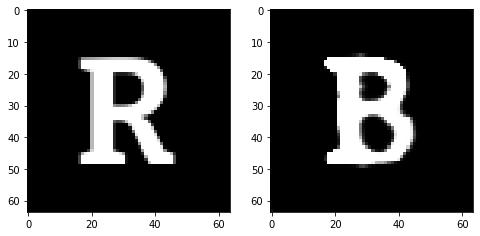

Epoch 27, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.459375996142626, Loss SSIM 4.348407864570618


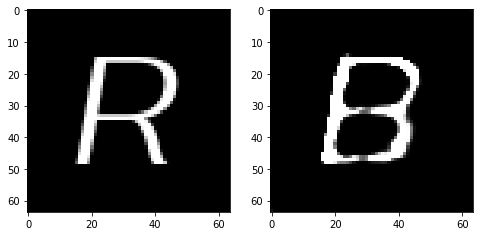

Epoch 28, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.459034599363804, Loss SSIM 4.32525908946991


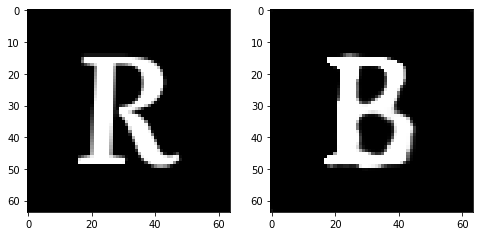

Epoch 28, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.460230305790901, Loss SSIM 4.421803176403046


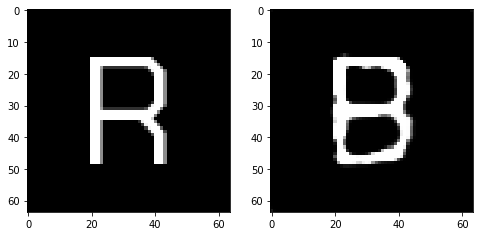

Epoch 29, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.5160201229155064, Loss SSIM 4.39557683467865


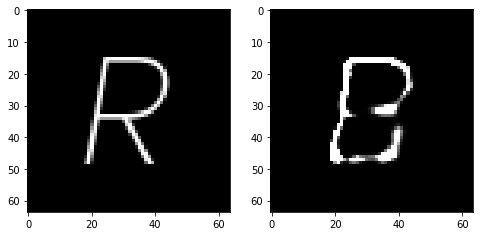

Epoch 29, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.391987342387438, Loss SSIM 4.20511931180954


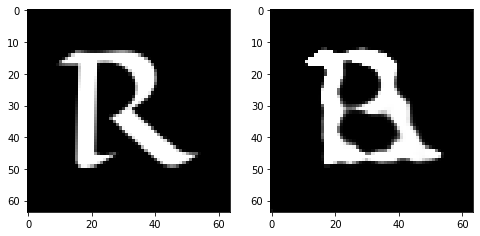

Epoch 30, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.4899273067712784, Loss SSIM 4.368073880672455


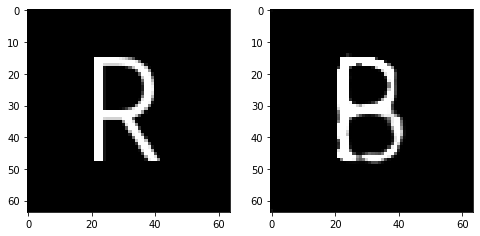

Epoch 30, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.3850266188383102, Loss SSIM 4.249667465686798


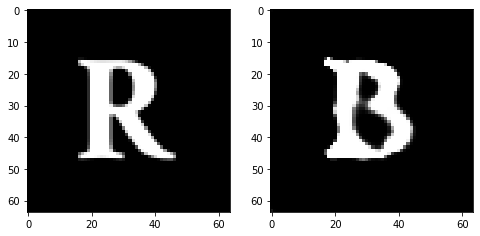

Epoch 31, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.411221709102392, Loss SSIM 4.271735072135925


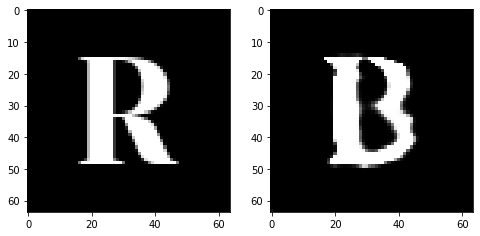

Epoch 31, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.452691461890936, Loss SSIM 4.332620203495026


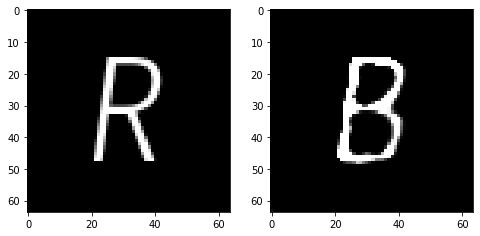

Epoch 32, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.380743272602558, Loss SSIM 4.22998183965683


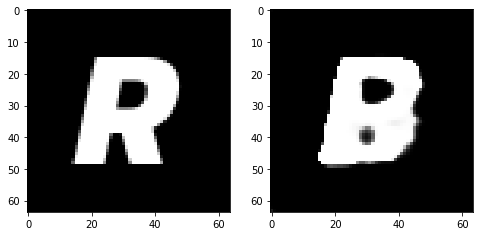

Epoch 32, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.445746161043644, Loss SSIM 4.315107524394989


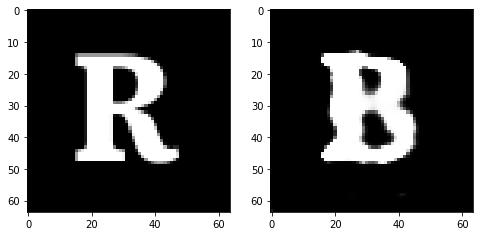

Epoch 33, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.350590381771326, Loss SSIM 4.178424835205078


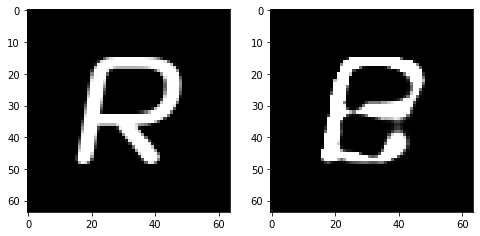

Epoch 33, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.441976059228182, Loss SSIM 4.321117520332336


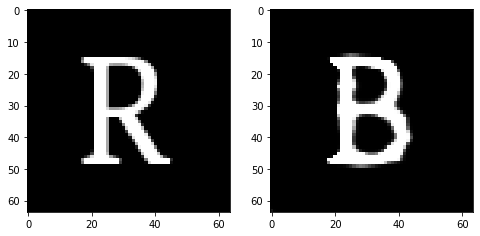

Epoch 34, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.421233721077442, Loss SSIM 4.31593918800354


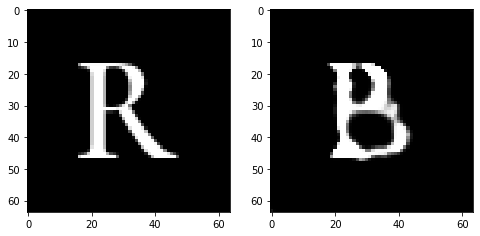

Epoch 34, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.3698392026126385, Loss SSIM 4.127791047096252


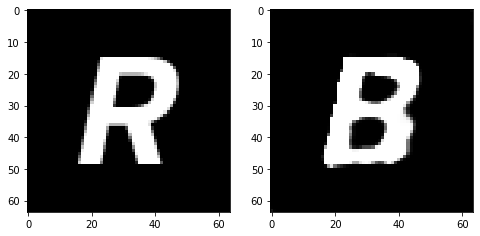

Epoch 35, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.42872603982687, Loss SSIM 4.314697265625


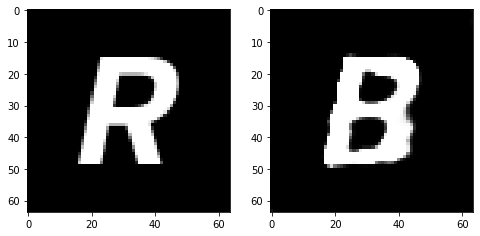

Epoch 35, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.3535893894732, Loss SSIM 4.199497103691101


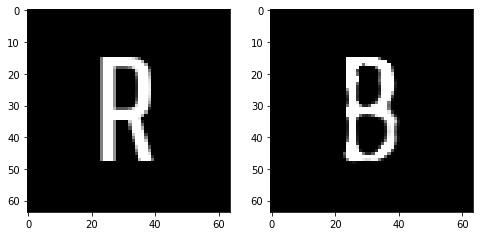

Epoch 36, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.49177323281765, Loss SSIM 4.367151141166687


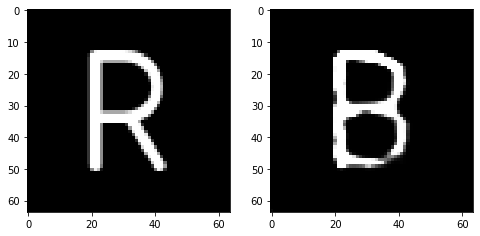

Epoch 36, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.3447222150862217, Loss SSIM 4.197672128677368


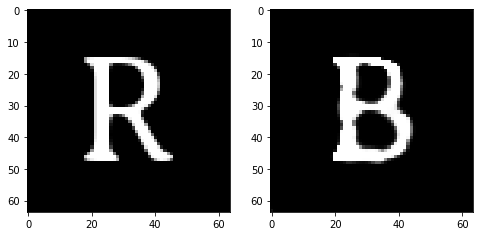

Epoch 37, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.487224753946066, Loss SSIM 4.42963981628418


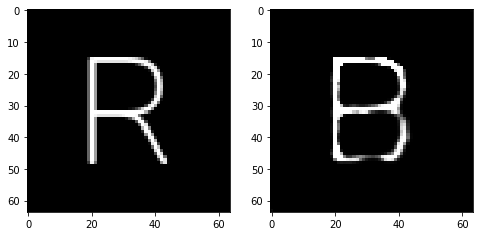

Epoch 37, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.3673090673983097, Loss SSIM 4.204276144504547


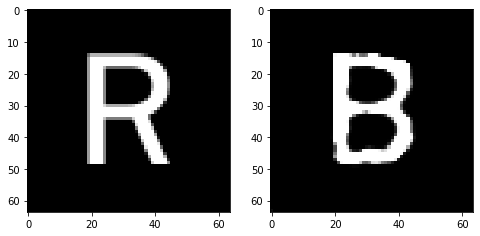

Epoch 38, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.335557907819748, Loss SSIM 4.099328696727753


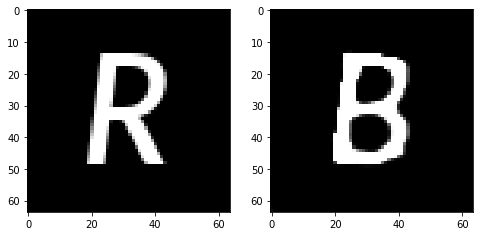

Epoch 38, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.355540554970503, Loss SSIM 4.2370129227638245


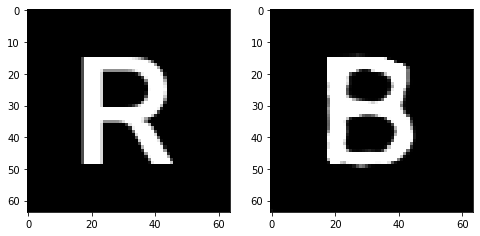

Epoch 39, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.3494347520172596, Loss SSIM 4.221138060092926


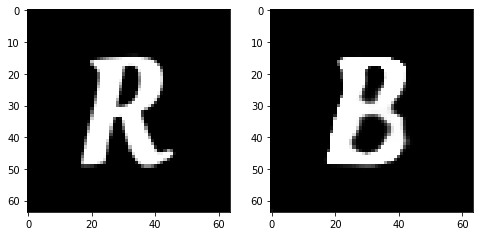

Epoch 39, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.3334868997335434, Loss SSIM 4.130942702293396


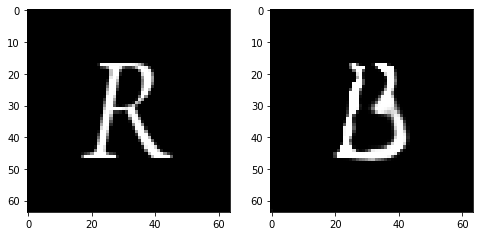

Epoch 40, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.370080728083849, Loss SSIM 4.225904881954193


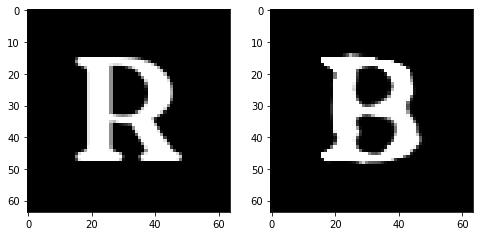

Epoch 40, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.3330615796148777, Loss SSIM 4.135134279727936


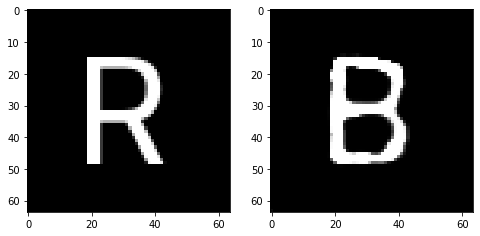

Epoch 41, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.3995726965367794, Loss SSIM 4.266359388828278


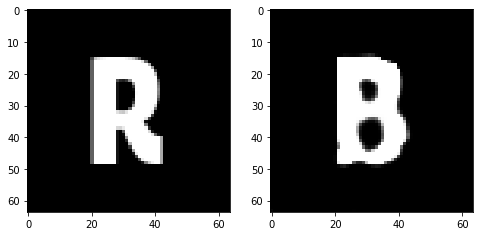

Epoch 41, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2844048216938972, Loss SSIM 4.1110005378723145


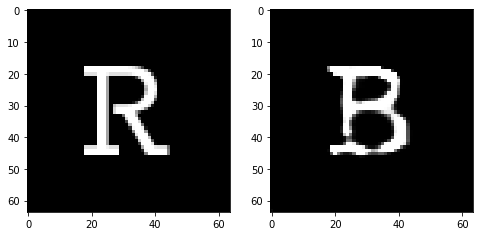

Epoch 42, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.319865107536316, Loss SSIM 4.189781069755554


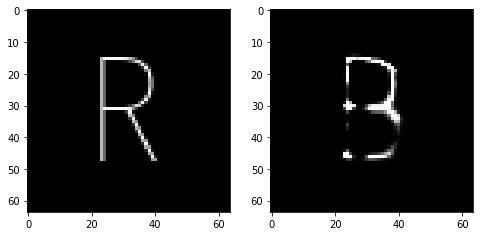

Epoch 42, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2919485047459602, Loss SSIM 4.0496527552604675


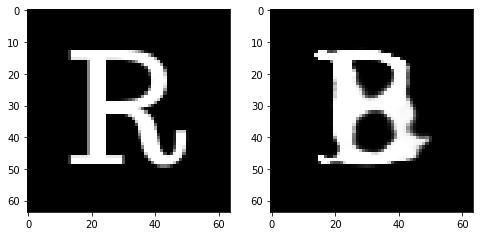

Epoch 43, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2258647978305817, Loss SSIM 3.9703596234321594


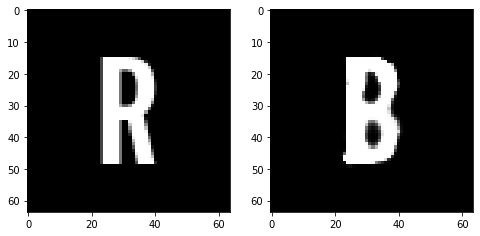

Epoch 43, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.388699233531952, Loss SSIM 4.234620153903961


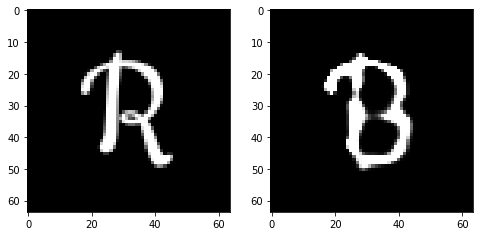

Epoch 44, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2947465665638447, Loss SSIM 4.119350731372833


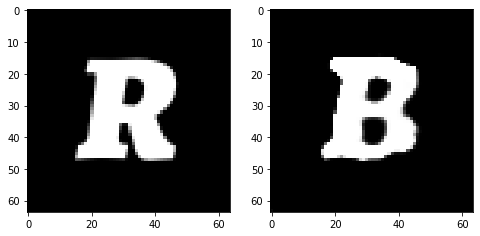

Epoch 44, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.338762443512678, Loss SSIM 4.152080416679382


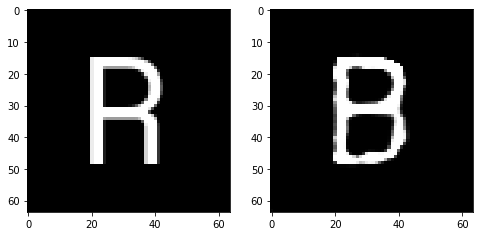

Epoch 45, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2887484580278397, Loss SSIM 4.074418723583221


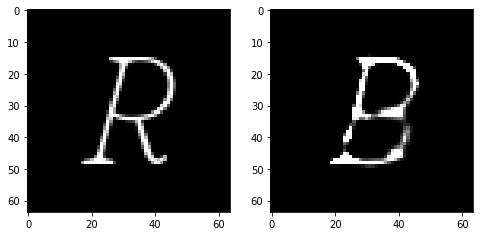

Epoch 45, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.298908568918705, Loss SSIM 4.105025291442871


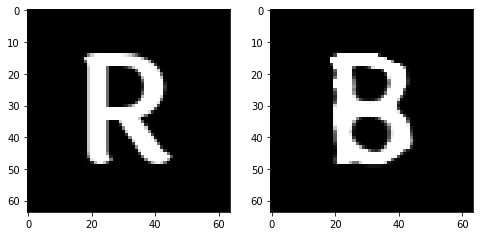

Epoch 46, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.332778427749872, Loss SSIM 4.086016476154327


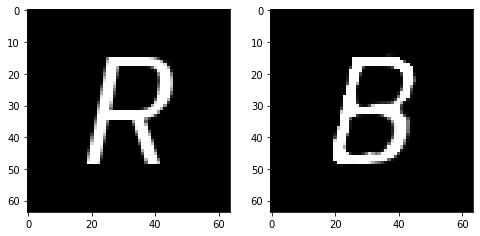

Epoch 46, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.247054487466812, Loss SSIM 4.028518915176392


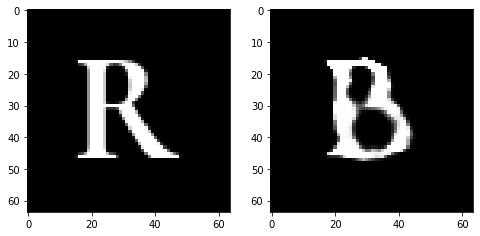

Epoch 47, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.26830155774951, Loss SSIM 4.098986268043518


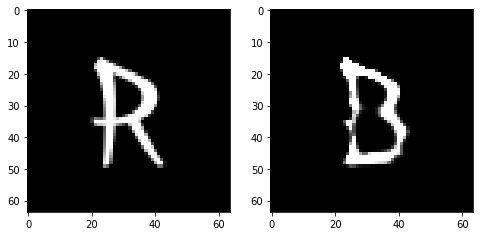

Epoch 47, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.328734263777733, Loss SSIM 4.08087033033371


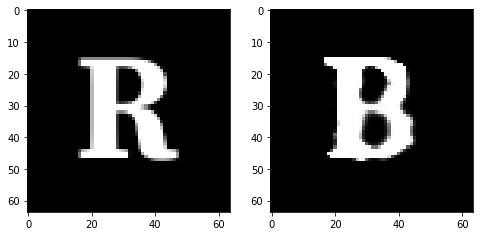

Epoch 48, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.223443638533354, Loss SSIM 4.020315229892731


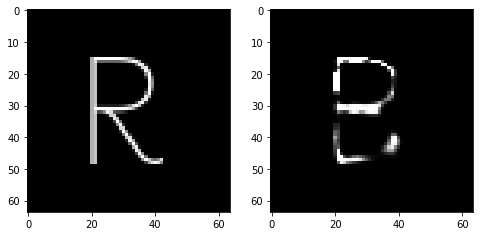

Epoch 48, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.258454404771328, Loss SSIM 3.9567824602127075


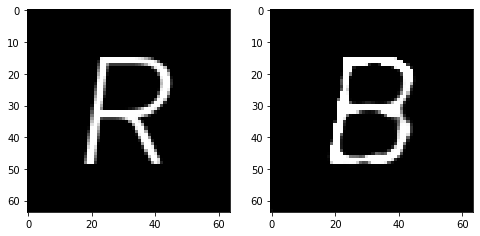

Epoch 49, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2225231379270554, Loss SSIM 3.968752086162567


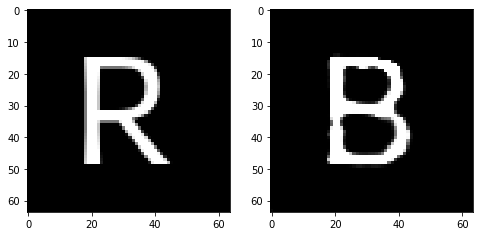

Epoch 49, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.27788745239377, Loss SSIM 4.020552694797516


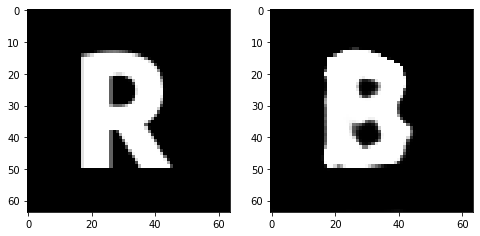

Epoch 50, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.273515999317169, Loss SSIM 4.089460670948029


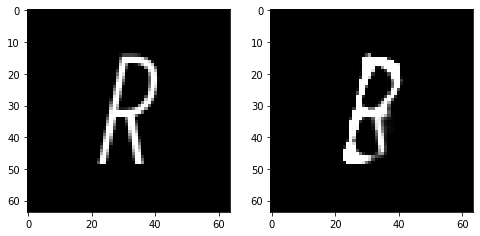

Epoch 50, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2114187628030777, Loss SSIM 3.927035868167877


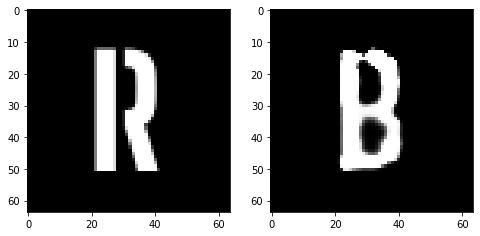

Epoch 51, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.222344808280468, Loss SSIM 3.900148391723633


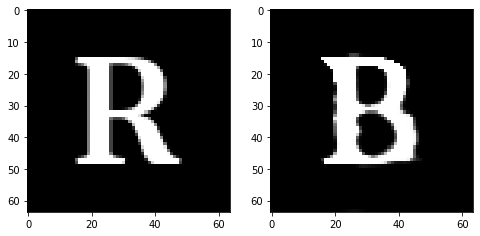

Epoch 51, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.274511594325304, Loss SSIM 4.0865296721458435


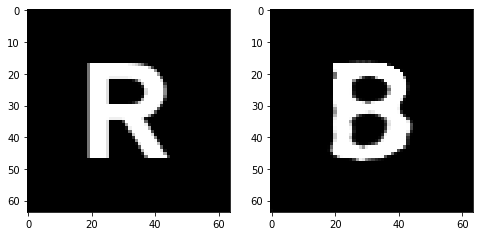

Epoch 52, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.264504875987768, Loss SSIM 4.0501797795295715


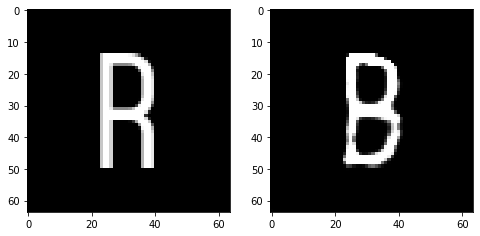

Epoch 52, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1803310103714466, Loss SSIM 3.846378207206726


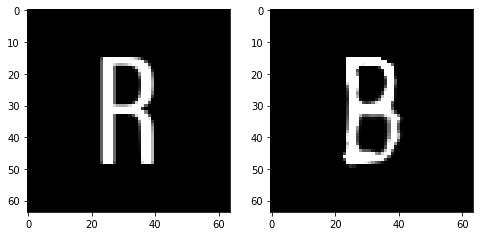

Epoch 53, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2283898554742336, Loss SSIM 3.9409731030464172


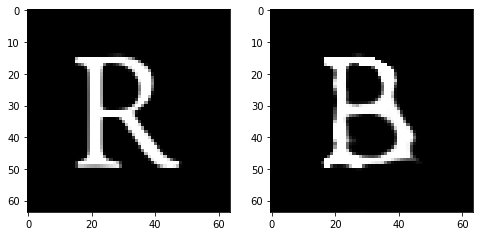

Epoch 53, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.187897339463234, Loss SSIM 3.8871634006500244


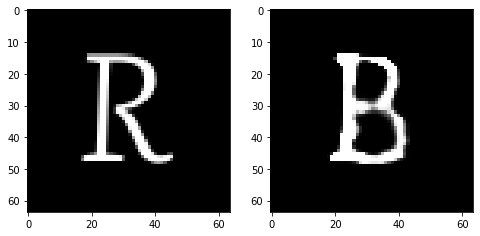

Epoch 54, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2311012223362923, Loss SSIM 3.900607109069824


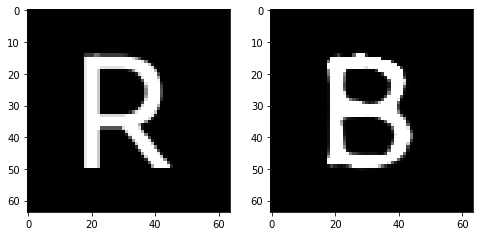

Epoch 54, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1975313909351826, Loss SSIM 3.9284490942955017


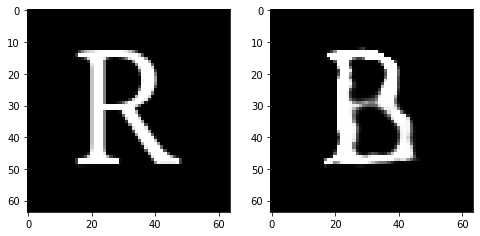

Epoch 55, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2394216023385525, Loss SSIM 4.081437766551971


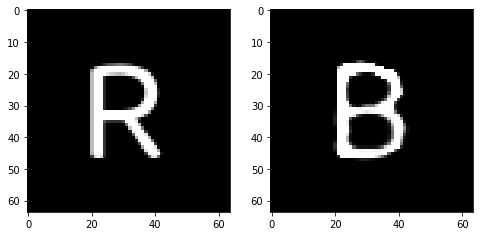

Epoch 55, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1961624808609486, Loss SSIM 3.816789209842682


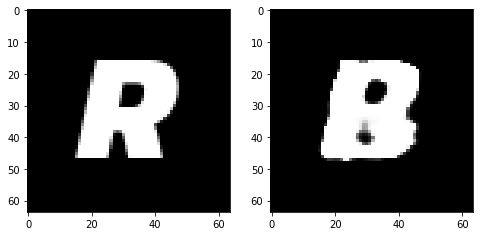

Epoch 56, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2827515676617622, Loss SSIM 4.044434547424316


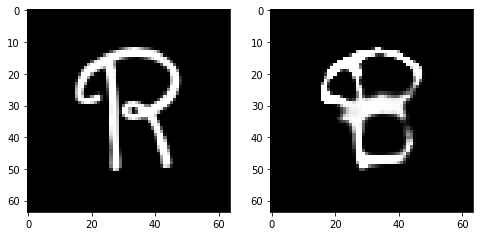

Epoch 56, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.163535416126251, Loss SSIM 3.8567506074905396


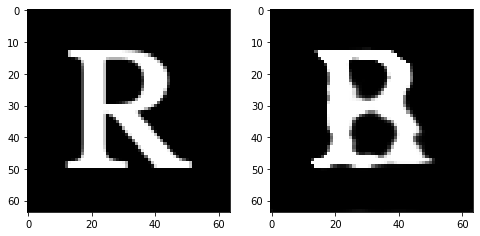

Epoch 57, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2367187179625034, Loss SSIM 3.945922613143921


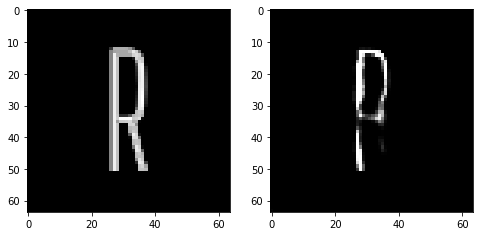

Epoch 57, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1932466849684715, Loss SSIM 3.9303581714630127


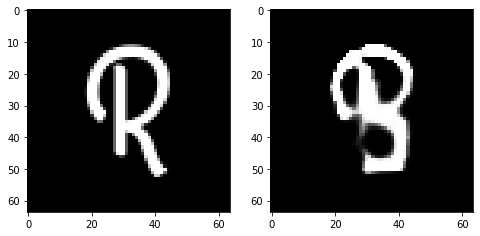

Epoch 58, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.288807462900877, Loss SSIM 4.048444211483002


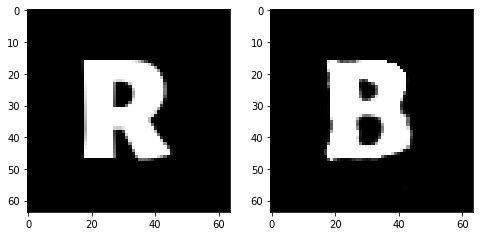

Epoch 58, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.137763384729624, Loss SSIM 3.8408798575401306


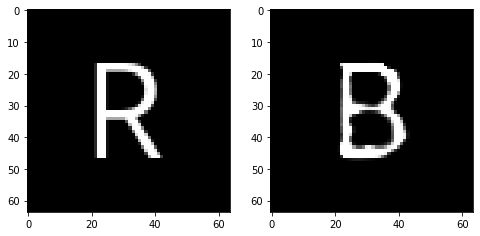

Epoch 59, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1713981702923775, Loss SSIM 3.8870730996131897


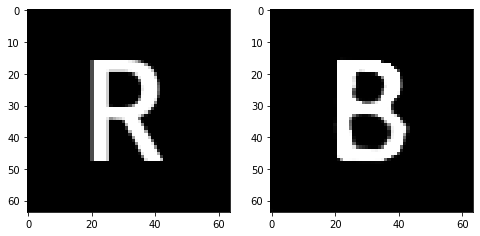

Epoch 59, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1828779093921185, Loss SSIM 3.887471914291382


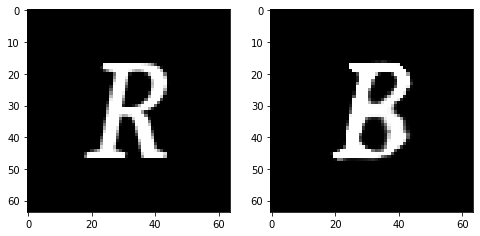

Epoch 60, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2668712697923183, Loss SSIM 4.095030665397644


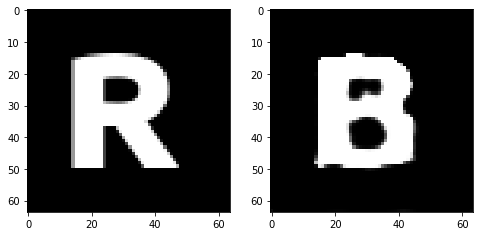

Epoch 60, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1148858554661274, Loss SSIM 3.8043404817581177


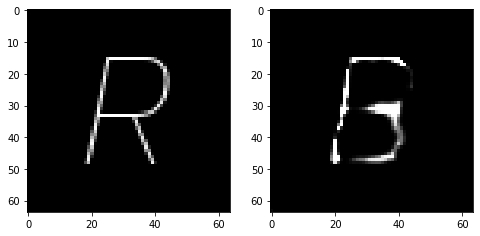

Epoch 61, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.17608455196023, Loss SSIM 3.921693444252014


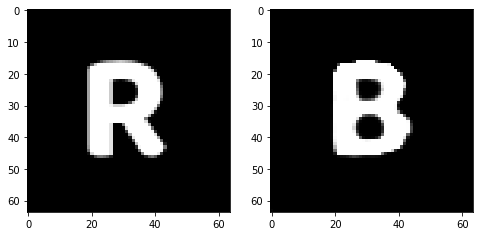

Epoch 61, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.200549267232418, Loss SSIM 3.9037843346595764


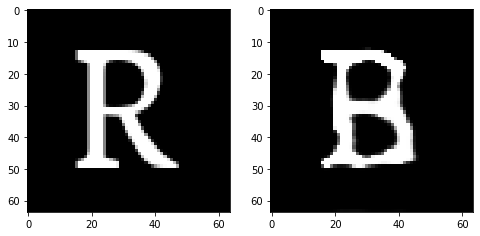

Epoch 62, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.234680086374283, Loss SSIM 3.9737796783447266


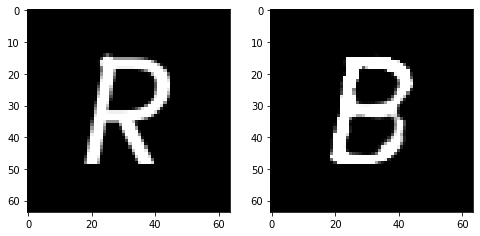

Epoch 62, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1192781925201416, Loss SSIM 3.771397113800049


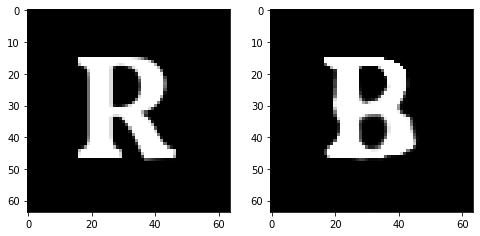

Epoch 63, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1919289752840996, Loss SSIM 3.9342336654663086


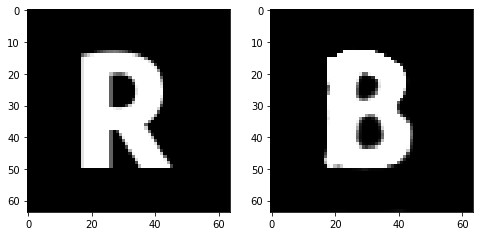

Epoch 63, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.171714846044779, Loss SSIM 3.8618324995040894


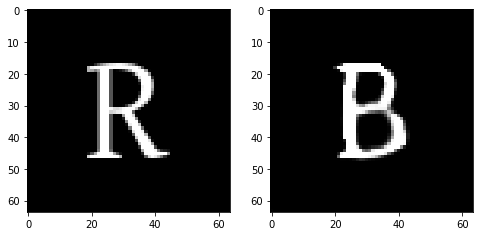

Epoch 64, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1947641260921955, Loss SSIM 3.8943141102790833


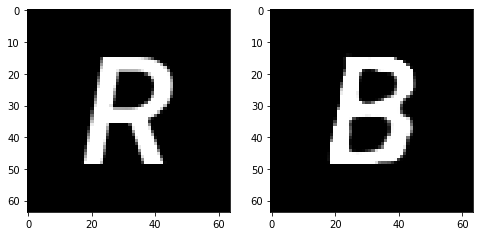

Epoch 64, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.137149680405855, Loss SSIM 3.7898898124694824


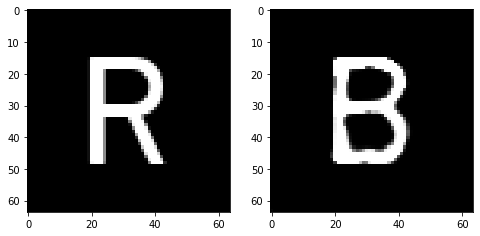

Epoch 65, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.175722226500511, Loss SSIM 3.8902317881584167


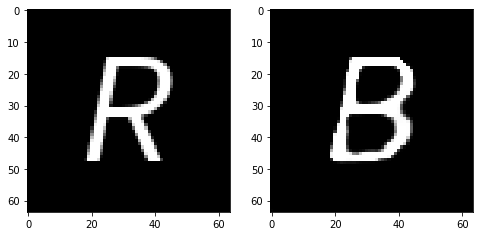

Epoch 65, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.154635239392519, Loss SSIM 3.855750262737274


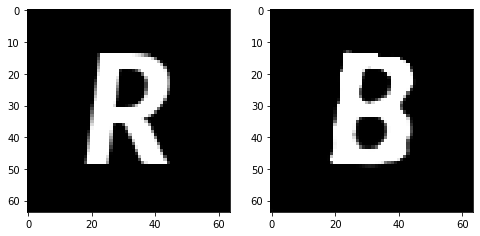

Epoch 66, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.177734099328518, Loss SSIM 3.891945779323578


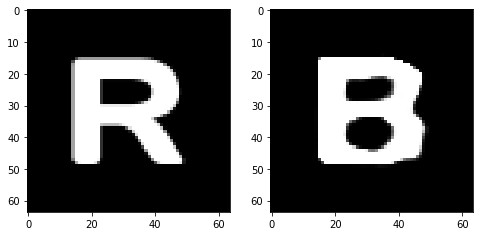

Epoch 66, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1994115076959133, Loss SSIM 3.9209702610969543


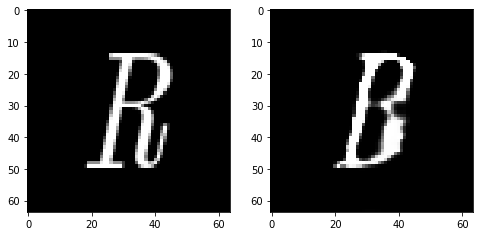

Epoch 67, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1444554030895233, Loss SSIM 3.874624192714691


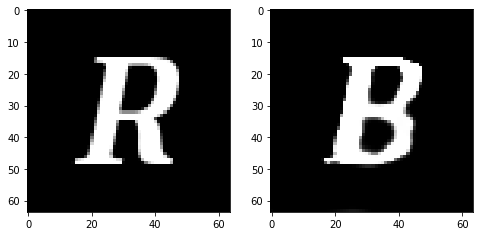

Epoch 67, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.240374829620123, Loss SSIM 3.931968629360199


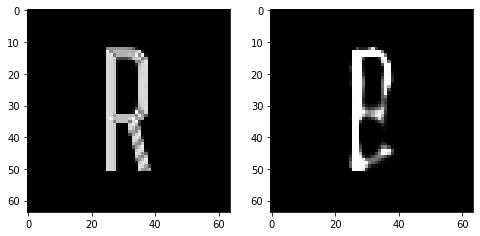

Epoch 68, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0820565447211266, Loss SSIM 3.7178019285202026


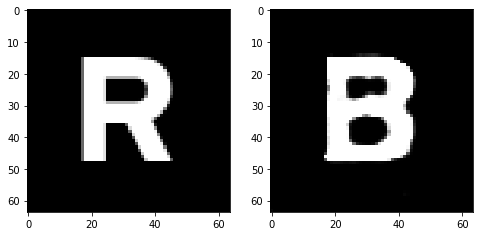

Epoch 68, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2223233953118324, Loss SSIM 3.931274890899658


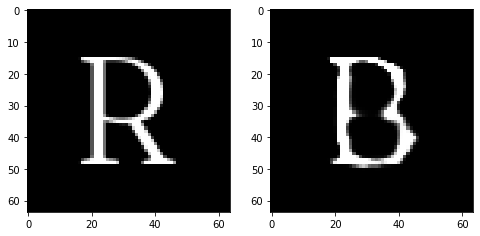

Epoch 69, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.180532593280077, Loss SSIM 3.8453990817070007


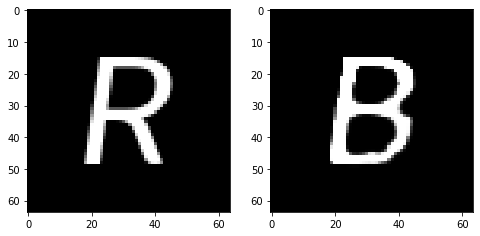

Epoch 69, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.121869906783104, Loss SSIM 3.8285396099090576


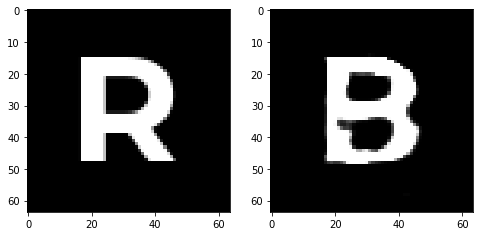

Epoch 70, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1400456093251705, Loss SSIM 3.863686978816986


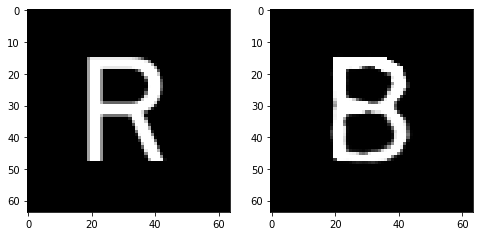

Epoch 70, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.19459405913949, Loss SSIM 3.904516875743866


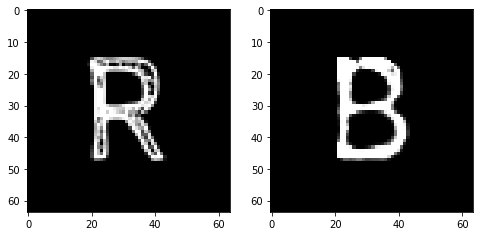

Epoch 71, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.175788953900337, Loss SSIM 3.9058691263198853


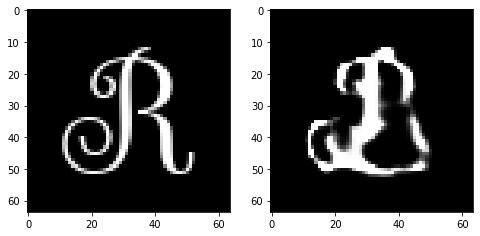

Epoch 71, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.125161297619343, Loss SSIM 3.785127639770508


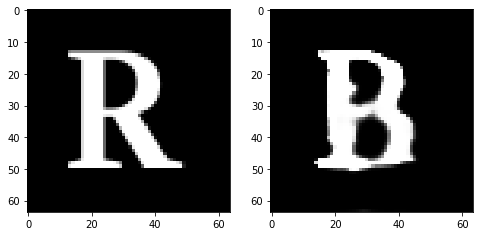

Epoch 72, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.119837388396263, Loss SSIM 3.8245885372161865


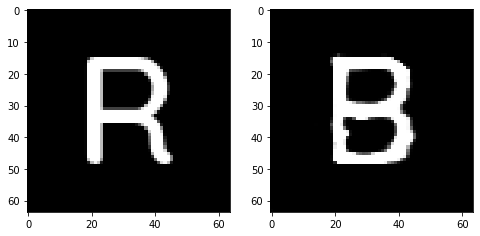

Epoch 72, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1788638159632683, Loss SSIM 3.84041827917099


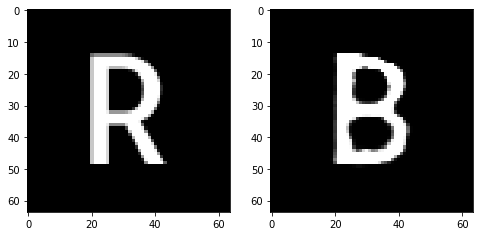

Epoch 73, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1820799484848976, Loss SSIM 3.896357536315918


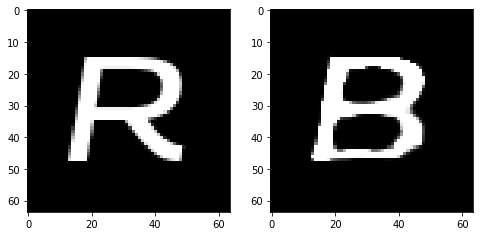

Epoch 73, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1502694487571716, Loss SSIM 3.8625177145004272


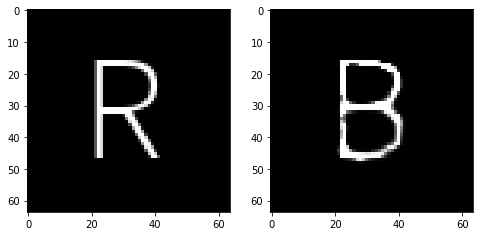

Epoch 74, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1423359364271164, Loss SSIM 3.8291359543800354


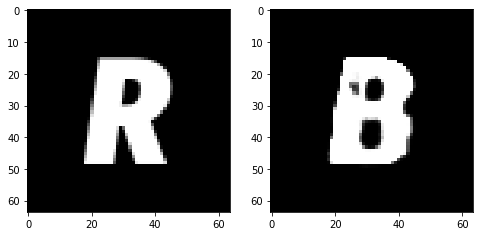

Epoch 74, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1342689283192158, Loss SSIM 3.803137481212616


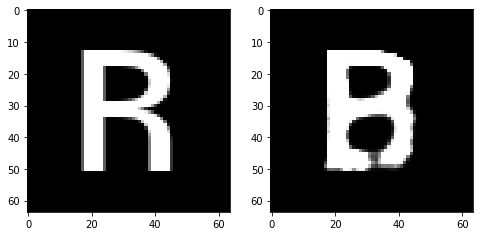

Epoch 75, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.14351686835289, Loss SSIM 3.787242114543915


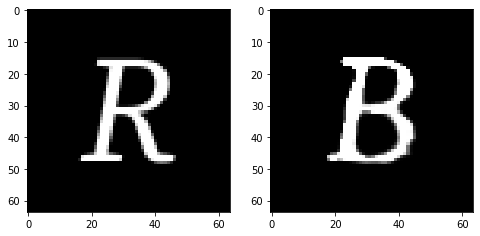

Epoch 75, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.177724067121744, Loss SSIM 3.914379298686981


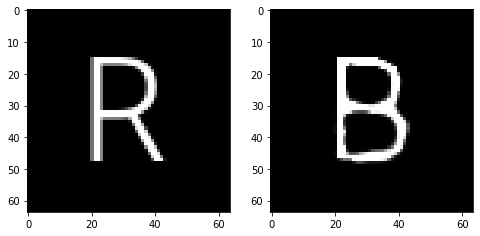

Epoch 76, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.189467918127775, Loss SSIM 3.9042834639549255


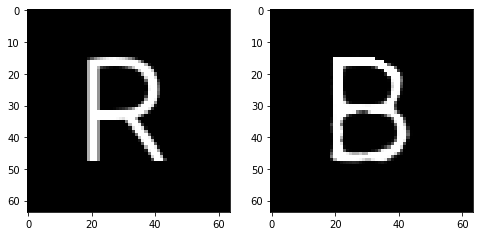

Epoch 76, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1135771572589874, Loss SSIM 3.7639042139053345


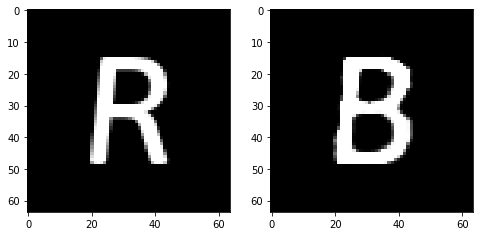

Epoch 77, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.139727756381035, Loss SSIM 3.761729121208191


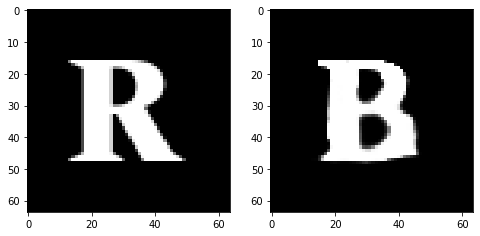

Epoch 77, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.124596893787384, Loss SSIM 3.8643640279769897


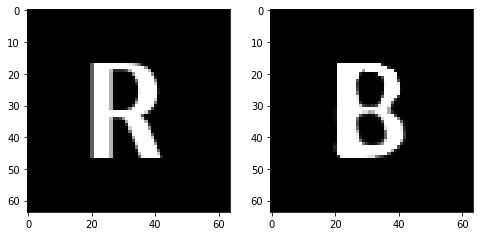

Epoch 78, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1278033889830112, Loss SSIM 3.7798444628715515


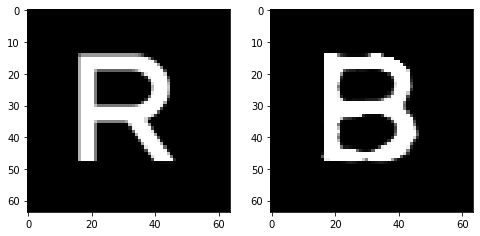

Epoch 78, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0922844521701336, Loss SSIM 3.719546854496002


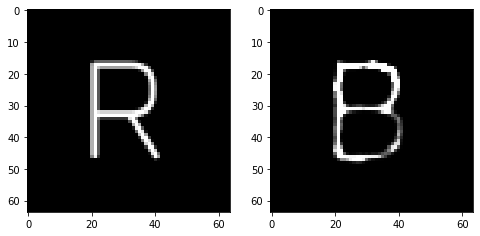

Epoch 79, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2387147545814514, Loss SSIM 3.9333930611610413


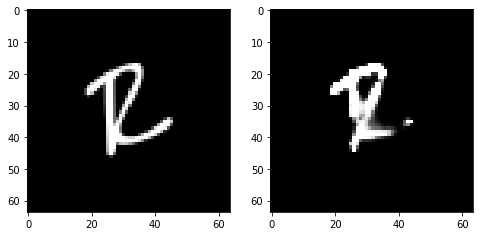

Epoch 79, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.120695285499096, Loss SSIM 3.826481580734253


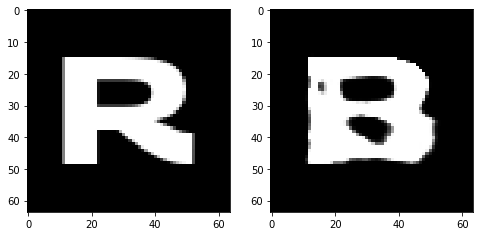

Epoch 80, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1809700801968575, Loss SSIM 3.8810723423957825


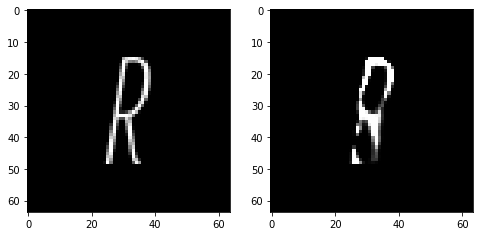

Epoch 80, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0812617130577564, Loss SSIM 3.6924532651901245


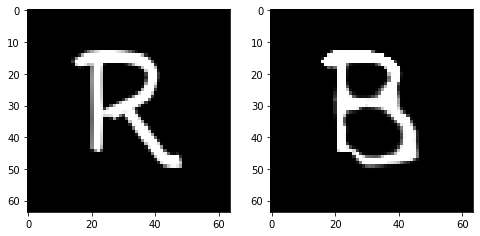

Epoch 81, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0964880771934986, Loss SSIM 3.7433730363845825


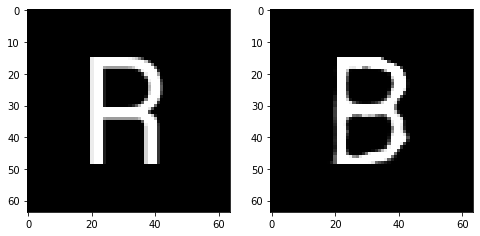

Epoch 81, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.098853975534439, Loss SSIM 3.730014383792877


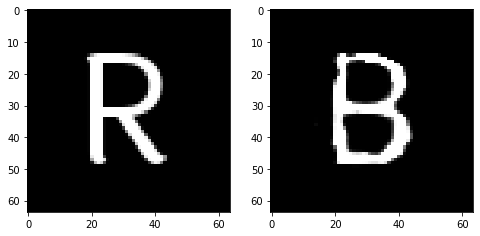

Epoch 82, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1690956875681877, Loss SSIM 3.837119698524475


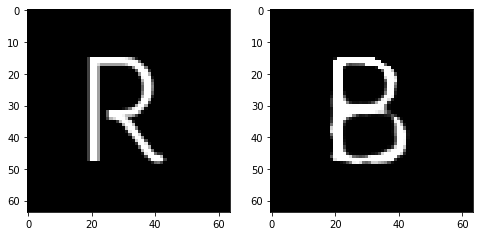

Epoch 82, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0753072686493397, Loss SSIM 3.710165321826935


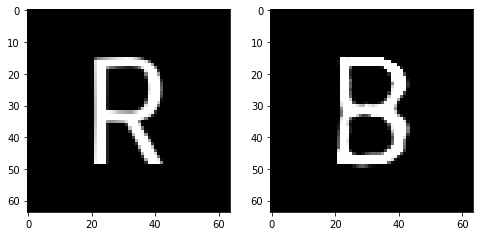

Epoch 83, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0941168777644634, Loss SSIM 3.699837386608124


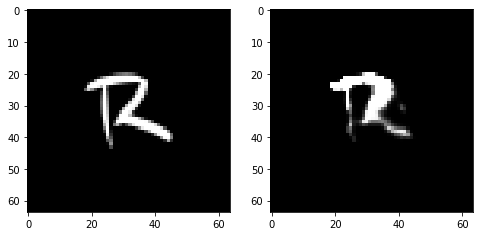

Epoch 83, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.13480631262064, Loss SSIM 3.844229221343994


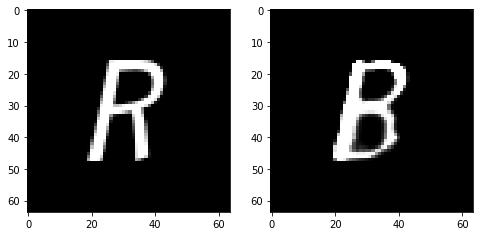

Epoch 84, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.156045477837324, Loss SSIM 3.8387064933776855


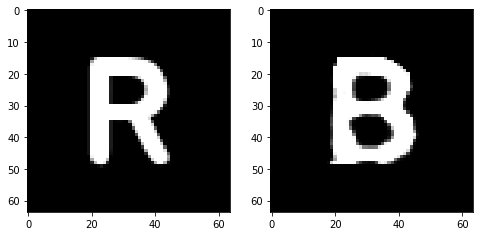

Epoch 84, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.129422605037689, Loss SSIM 3.8457512259483337


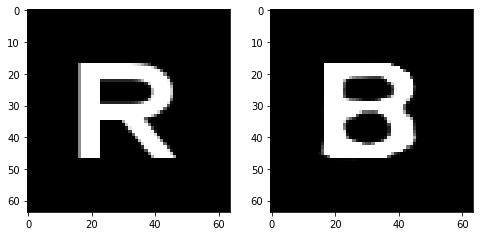

Epoch 85, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1545072868466377, Loss SSIM 3.8104077577590942


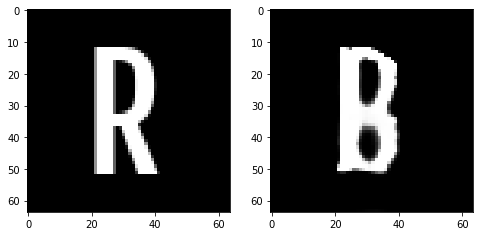

Epoch 85, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.106529351323843, Loss SSIM 3.756143033504486


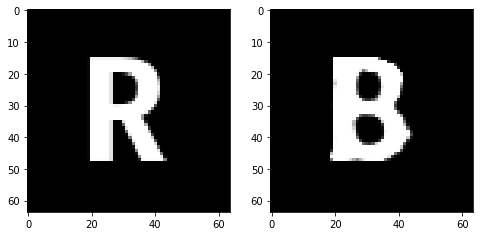

Epoch 86, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1366367265582085, Loss SSIM 3.830675959587097


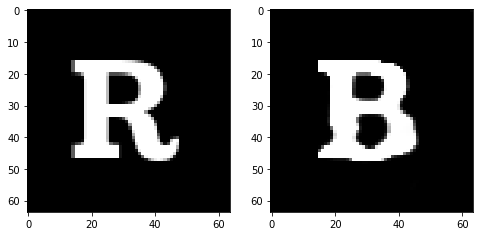

Epoch 86, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1154926903545856, Loss SSIM 3.747779965400696


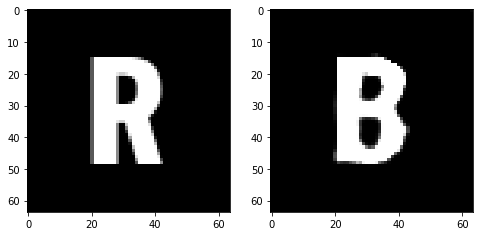

Epoch 87, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.202696993947029, Loss SSIM 3.9467639327049255


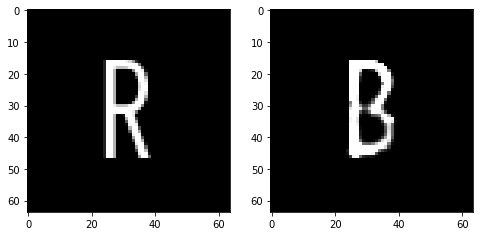

Epoch 87, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0923702120780945, Loss SSIM 3.7151471972465515


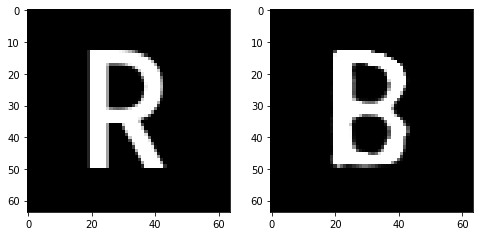

Epoch 88, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1705372147262096, Loss SSIM 3.873383641242981


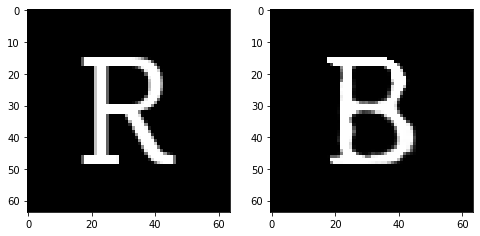

Epoch 88, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0239033102989197, Loss SSIM 3.6228803396224976


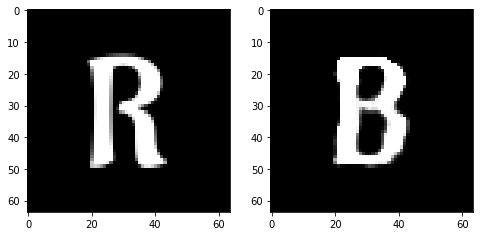

Epoch 89, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.145946618169546, Loss SSIM 3.8538458347320557


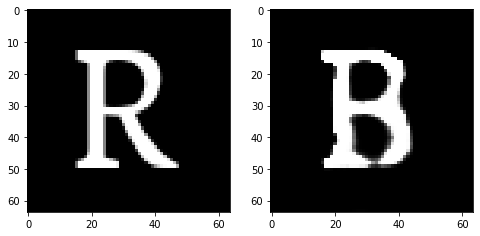

Epoch 89, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.11377876996994, Loss SSIM 3.762497067451477


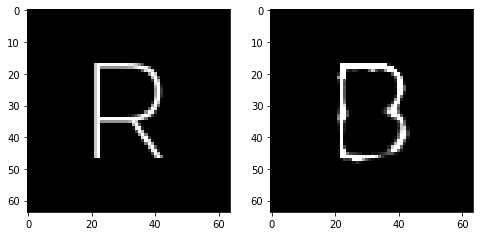

Epoch 90, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1720244847238064, Loss SSIM 3.825264811515808


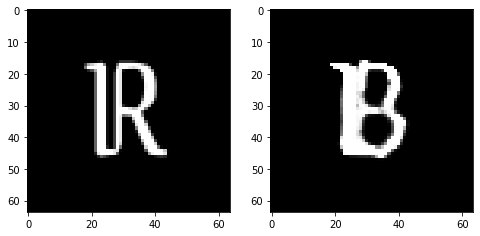

Epoch 90, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0908348970115185, Loss SSIM 3.750598430633545


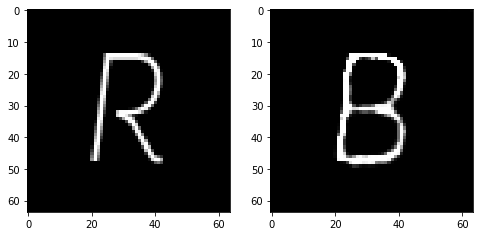

Epoch 91, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.171923242509365, Loss SSIM 3.8750356435775757


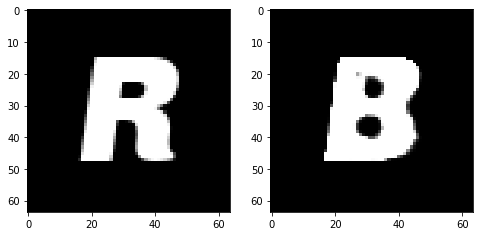

Epoch 91, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1707078479230404, Loss SSIM 3.8191139698028564


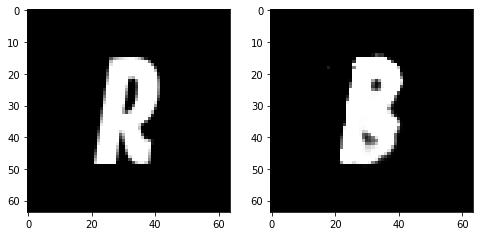

Epoch 92, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1849090792238712, Loss SSIM 3.883955180644989


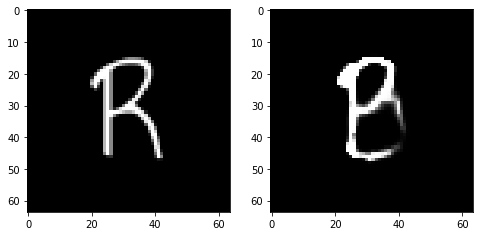

Epoch 92, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.01678104698658, Loss SSIM 3.5458284616470337


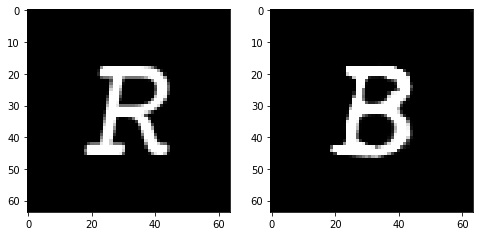

Epoch 93, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1230203099548817, Loss SSIM 3.7971519827842712


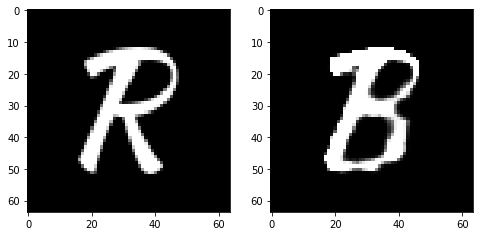

Epoch 93, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.085104566067457, Loss SSIM 3.6689730882644653


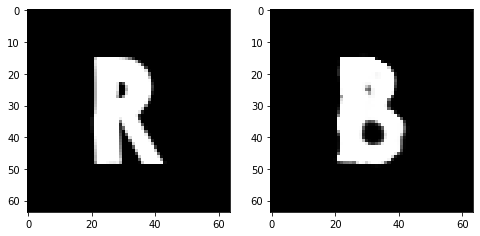

Epoch 94, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.089266497641802, Loss SSIM 3.799433708190918


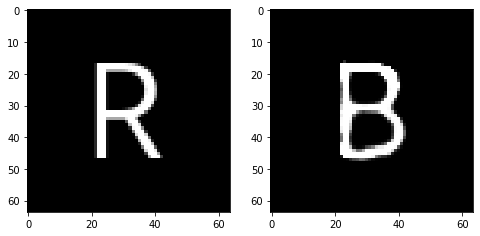

Epoch 94, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.105540405958891, Loss SSIM 3.687748074531555


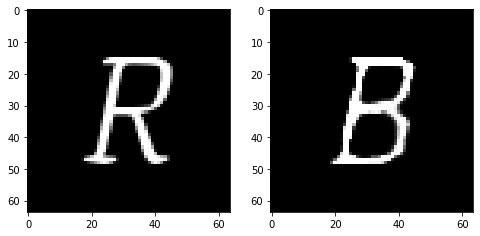

Epoch 95, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1038688495755196, Loss SSIM 3.755928158760071


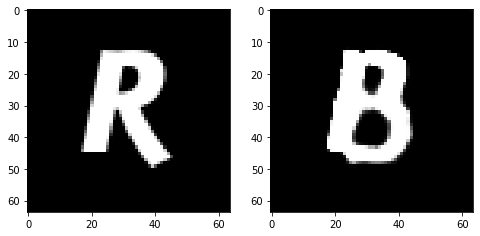

Epoch 95, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.082914389669895, Loss SSIM 3.6779943108558655


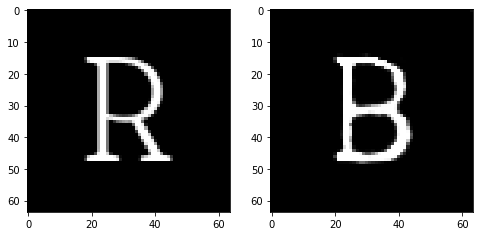

Epoch 96, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.099417742341757, Loss SSIM 3.6783448457717896


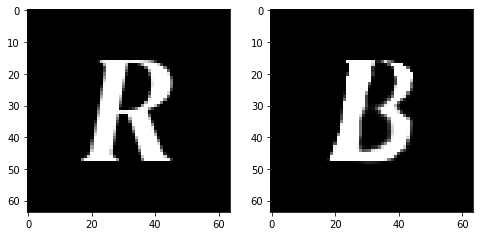

Epoch 96, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0955786257982254, Loss SSIM 3.739206552505493


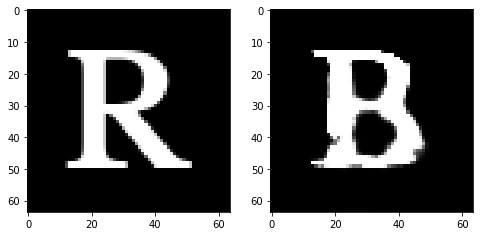

Epoch 97, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1102807968854904, Loss SSIM 3.712937653064728


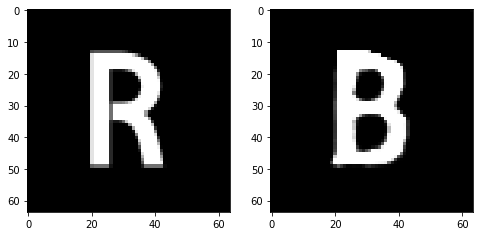

Epoch 97, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.0871079564094543, Loss SSIM 3.6978373527526855


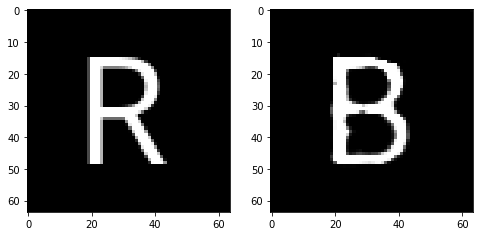

Epoch 98, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.112748458981514, Loss SSIM 3.766496181488037


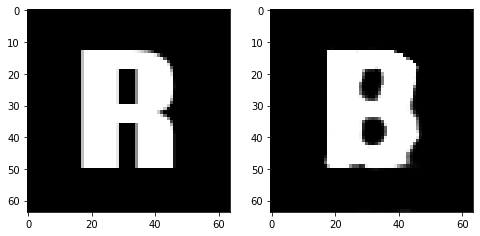

Epoch 98, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.110536653548479, Loss SSIM 3.7696605920791626


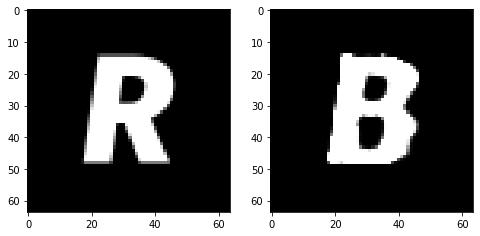

Epoch 99, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1092019453644753, Loss SSIM 3.756108582019806


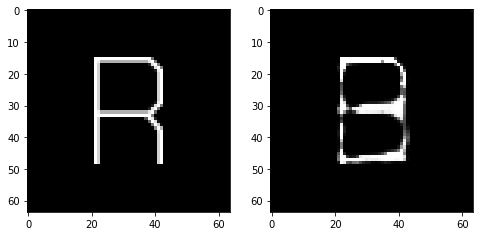

Epoch 99, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.105952352285385, Loss SSIM 3.673730432987213


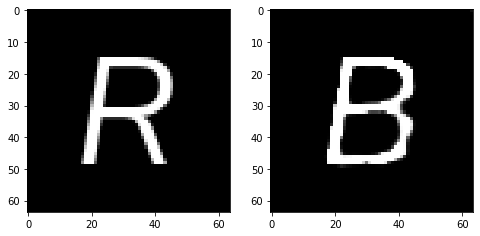

Epoch 100, Iteration 50, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.1033880785107613, Loss SSIM 3.773207664489746


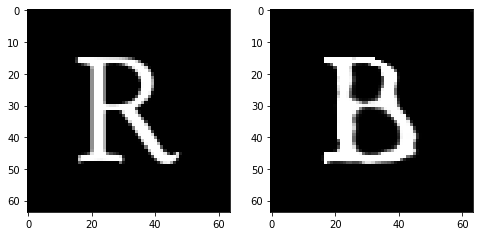

Epoch 100, Iteration 100, Loss D 5000.0, Loss Disc 0.0, Loss L1 3.2200502529740334, Loss SSIM 3.842885911464691


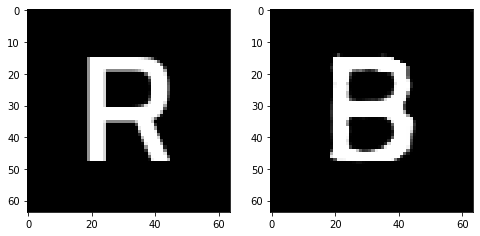

Done


In [175]:
main()

In [176]:
# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0

dataset = FontDataset(csv_file=fonts_csv, 
                      root_dir=dataroot, 
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(0.5, 0.5),
                      ]))

In [177]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=workers)

encdec = EncoderDecoder()
encdec.load_state_dict(torch.load('encdec-Copy1.pt'))
encdec.eval()

EncoderDecoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1same): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2back): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1back): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1strided): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2strided): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1strided): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2strided): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(

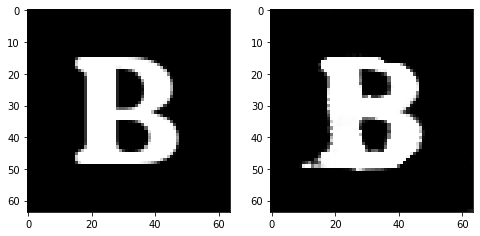

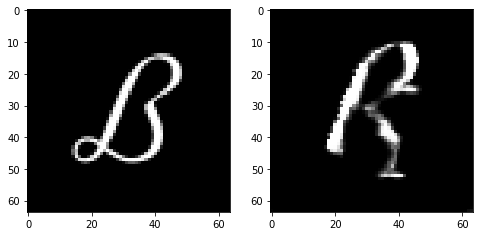

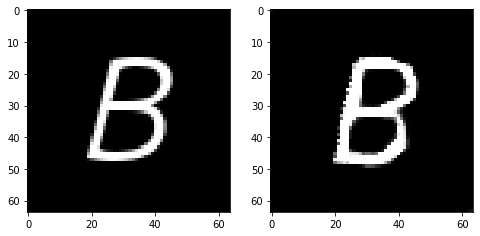

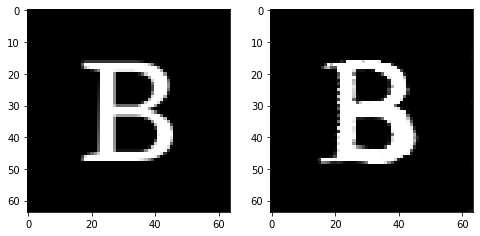

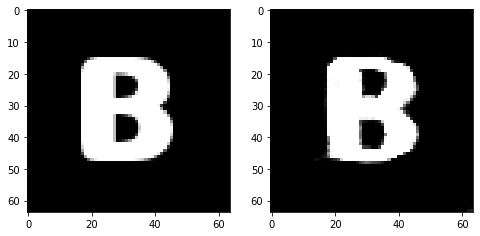

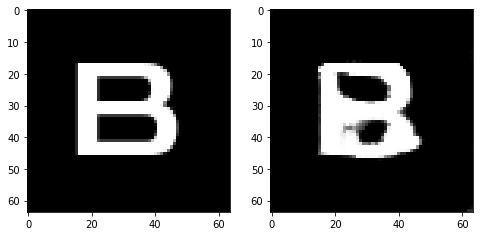

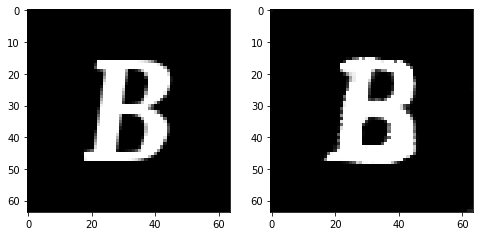

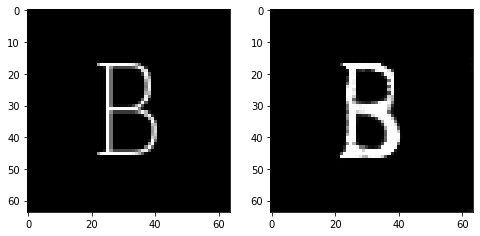

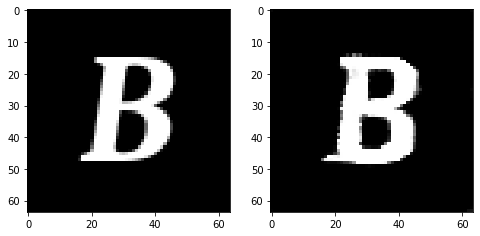

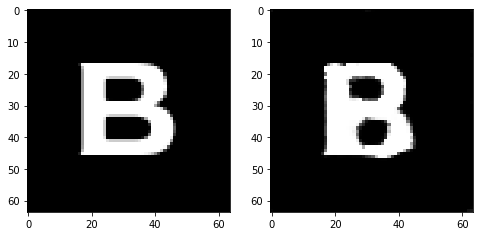

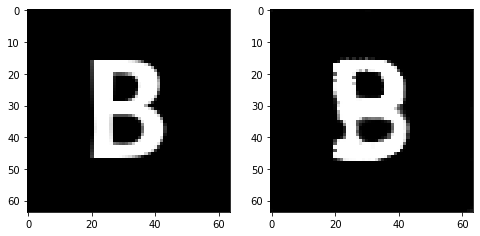

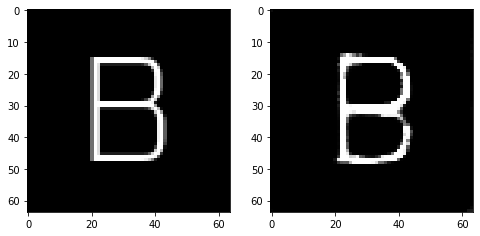

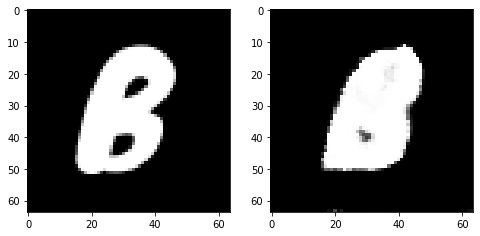

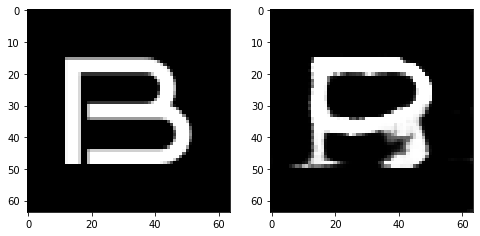

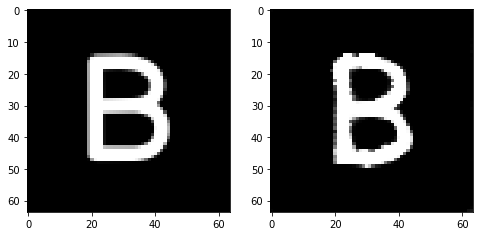

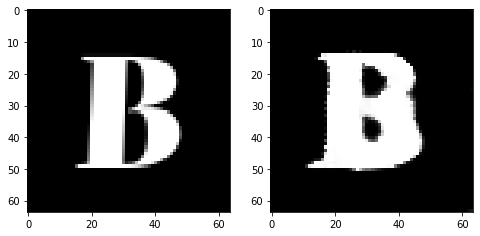

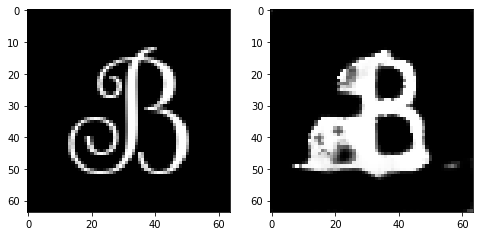

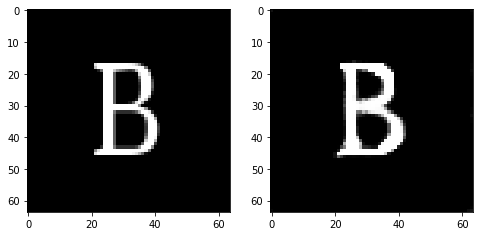

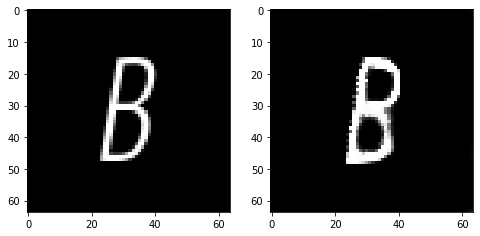

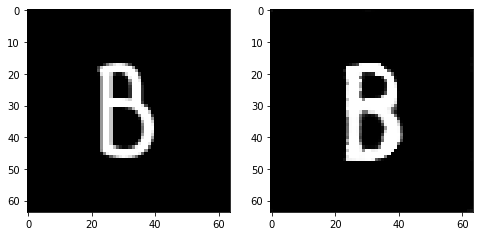

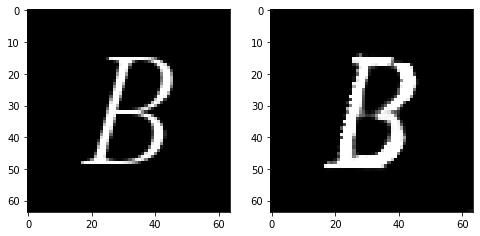

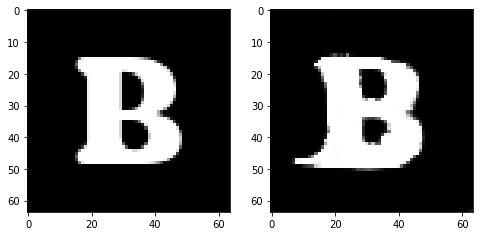

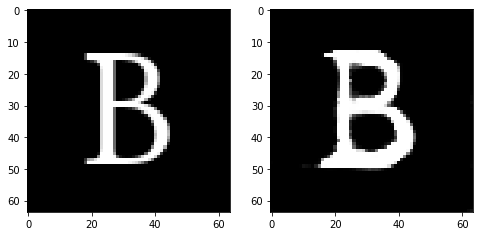

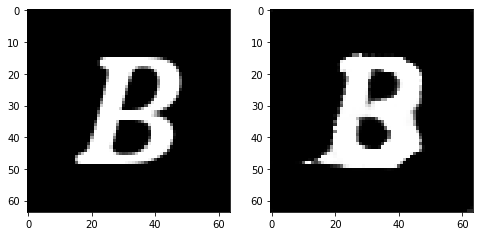

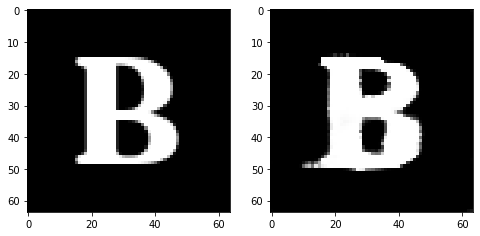

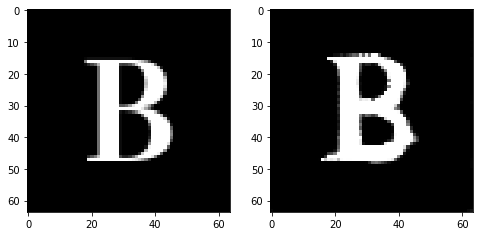

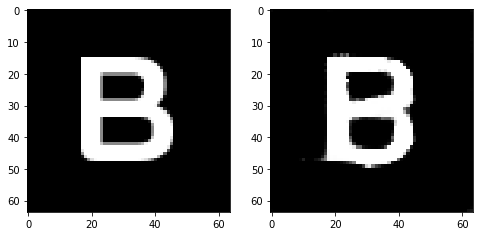

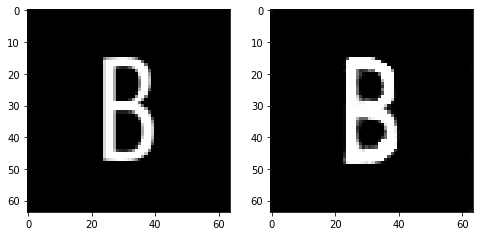

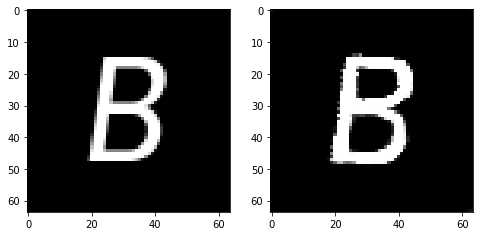

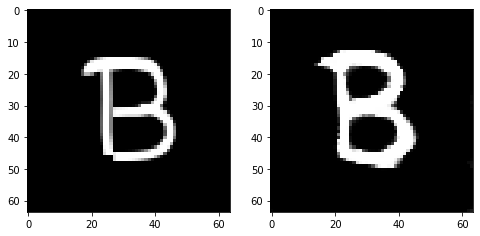

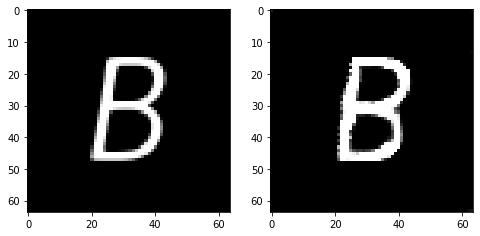

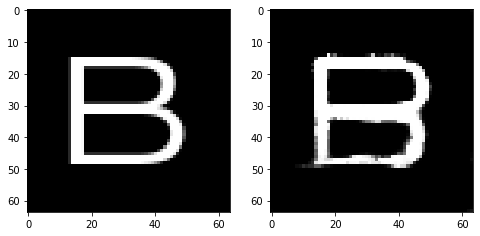

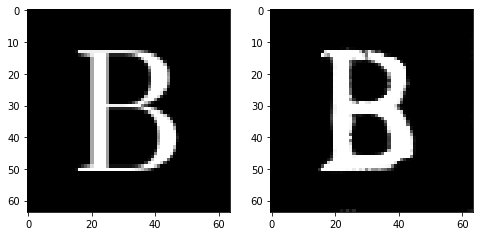

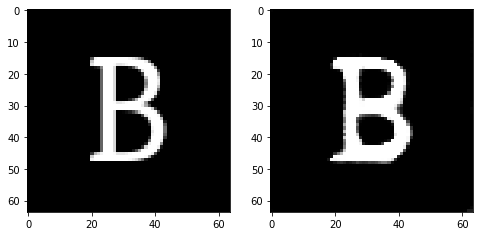

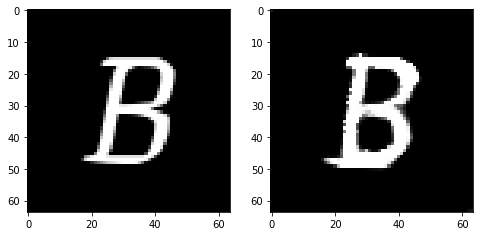

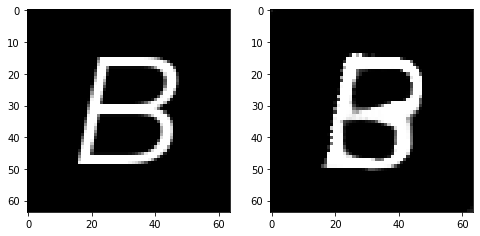

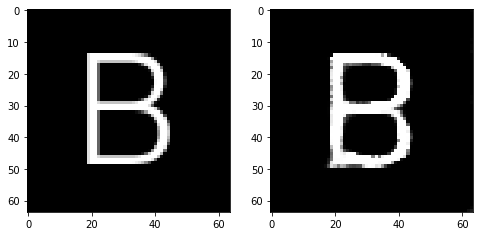

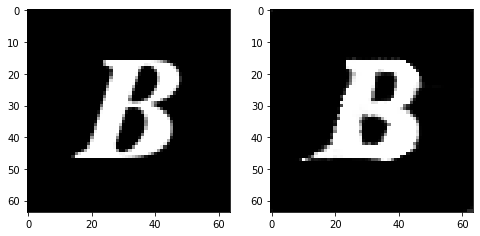

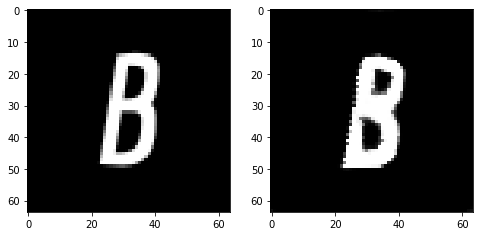

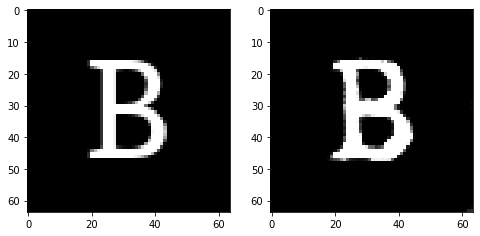

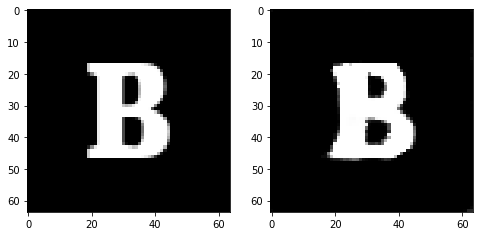

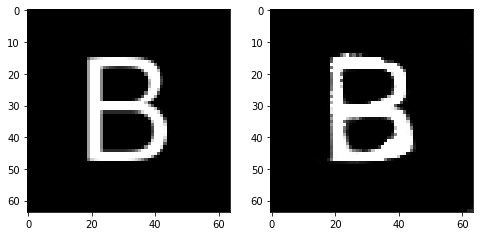

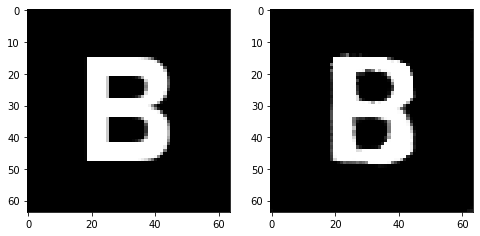

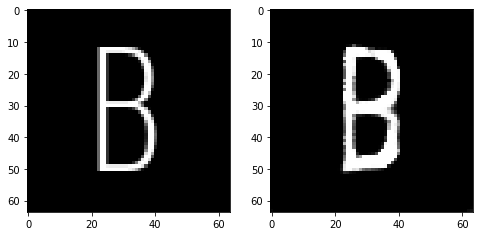

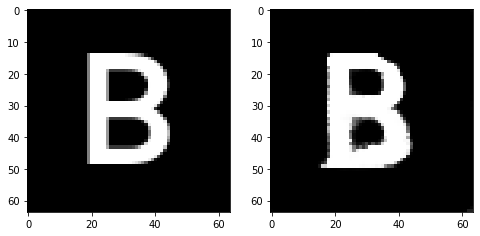

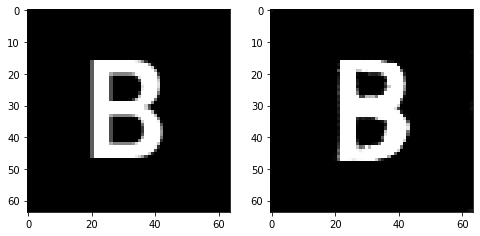

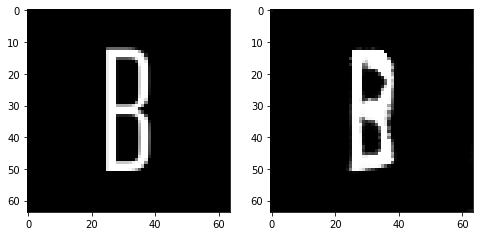

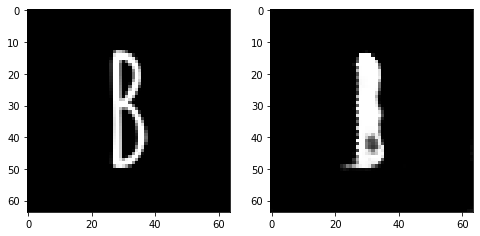

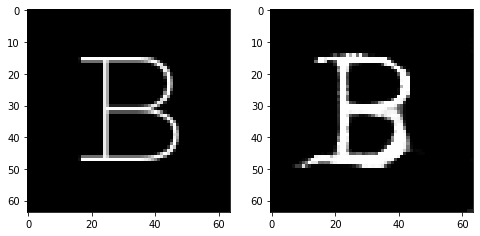

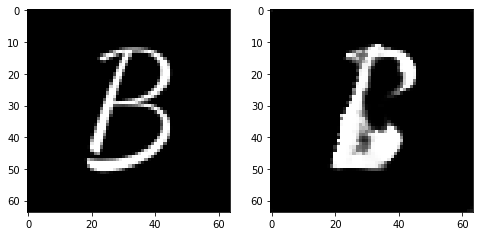

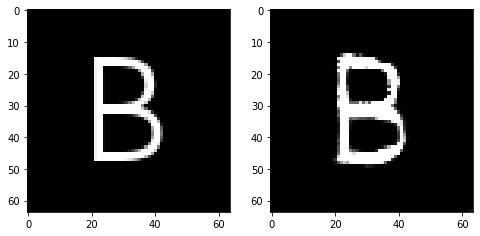

In [178]:
for i, data in enumerate(dataloader):
    if i > 50:
        break
    fig = plt.figure(figsize=(8, 8))
    output = encdec(data['c1'])
    fig.add_subplot(1, 2, 1)
    plt.imshow(data['c2'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(output[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.show()

In [26]:
font_set = pd.read_csv('fonts.csv', sep=' ', header=None)

letter_dir = './images/B'
for file in os.listdir(letter_dir):
    print(file)
    img = np.load(os.path.join(letter_dir, file))
    
    num = int(file.split('.')[0])
    font_name = font_set[1][num]
    print(font_name)
    
    plt.imshow(img, cmap='gray')
    plt.show()